Requirements: Pytorch, mat73, numpy

```pip install mat73```

相關論文： https://ieeexplore.ieee.org/document/9124646

In [6]:
import glob
from os.path import *
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import sys
import mat73
import matplotlib.pyplot as plt
from scipy.io import savemat
import os
import tqdm

In [7]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(
            scale_factor=2, mode='linear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffX = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet1d(nn.Module):
    def __init__(self, n_channels, n_classes, nfilter=24):
        super(UNet1d, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, nfilter)
        self.down1 = Down(nfilter, nfilter * 2)
        self.down2 = Down(nfilter * 2, nfilter * 4)
        self.down3 = Down(nfilter * 4, nfilter * 8)
        self.down4 = Down(nfilter * 8, nfilter * 8)
        self.up1 = Up(nfilter * 16, nfilter * 4)
        self.up2 = Up(nfilter * 8, nfilter * 2)
        self.up3 = Up(nfilter * 4, nfilter * 1)
        self.up4 = Up(nfilter * 2, nfilter)
        self.outc = OutConv(nfilter, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [8]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

..................................................mse loss:  353.65998138427733


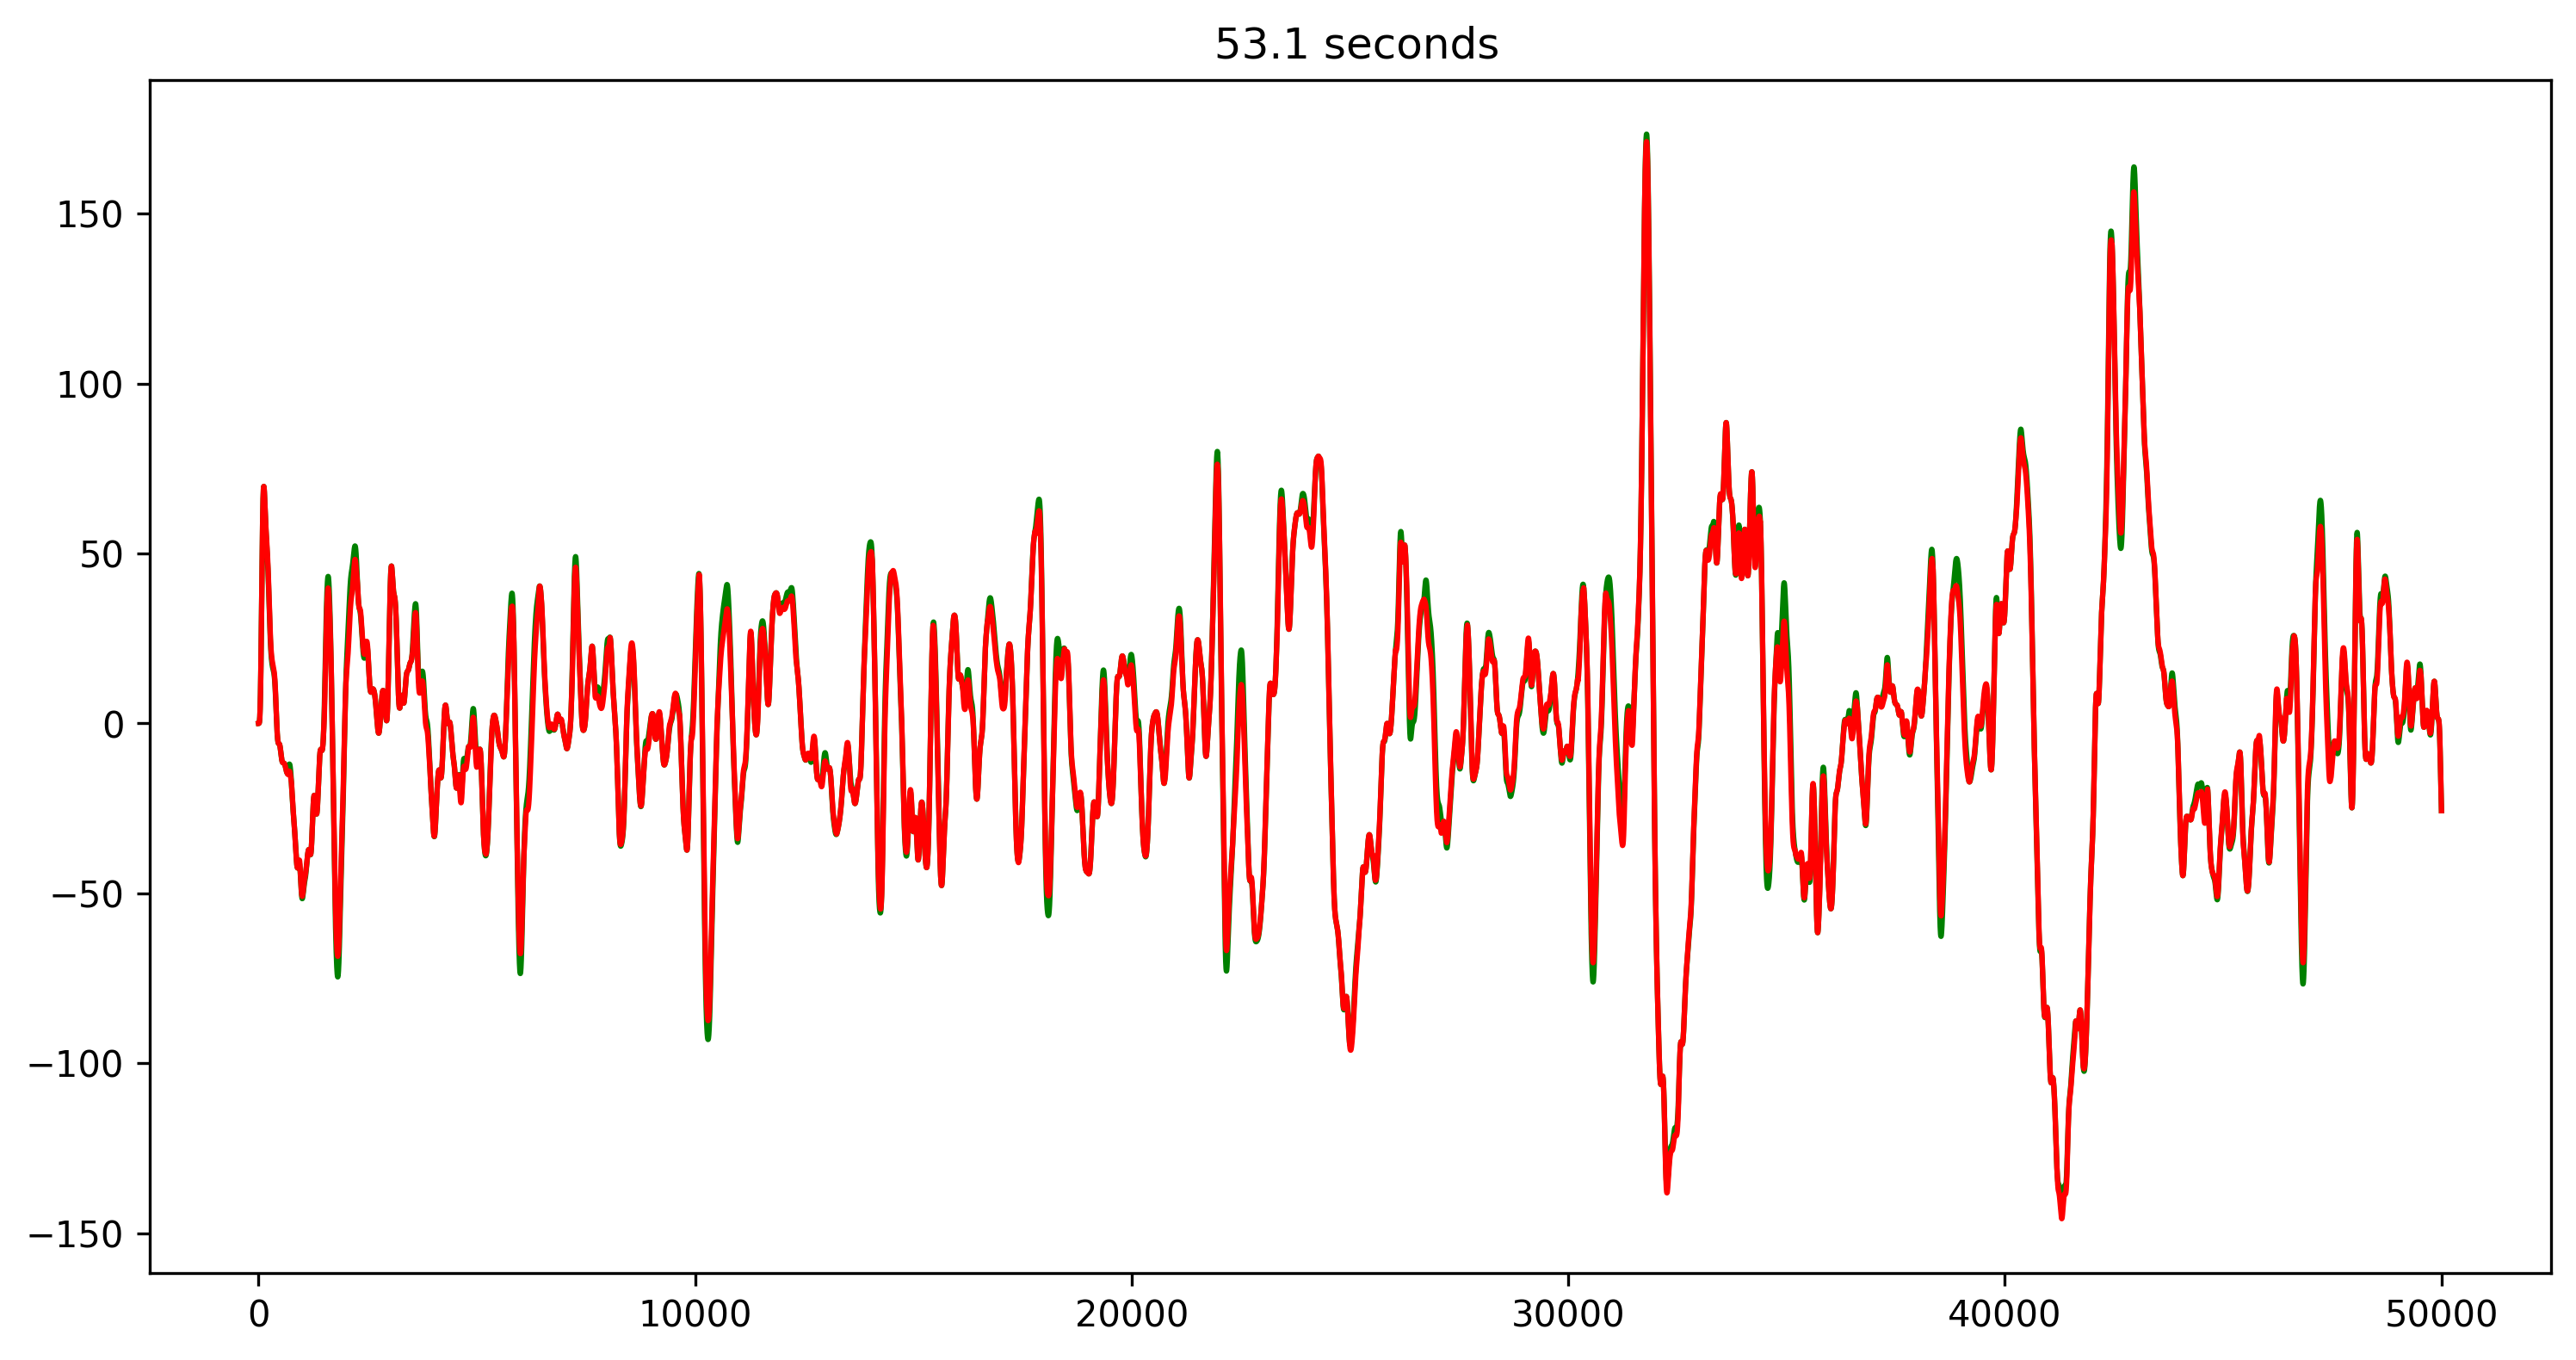

..................................................mse loss:  312.01286370849607


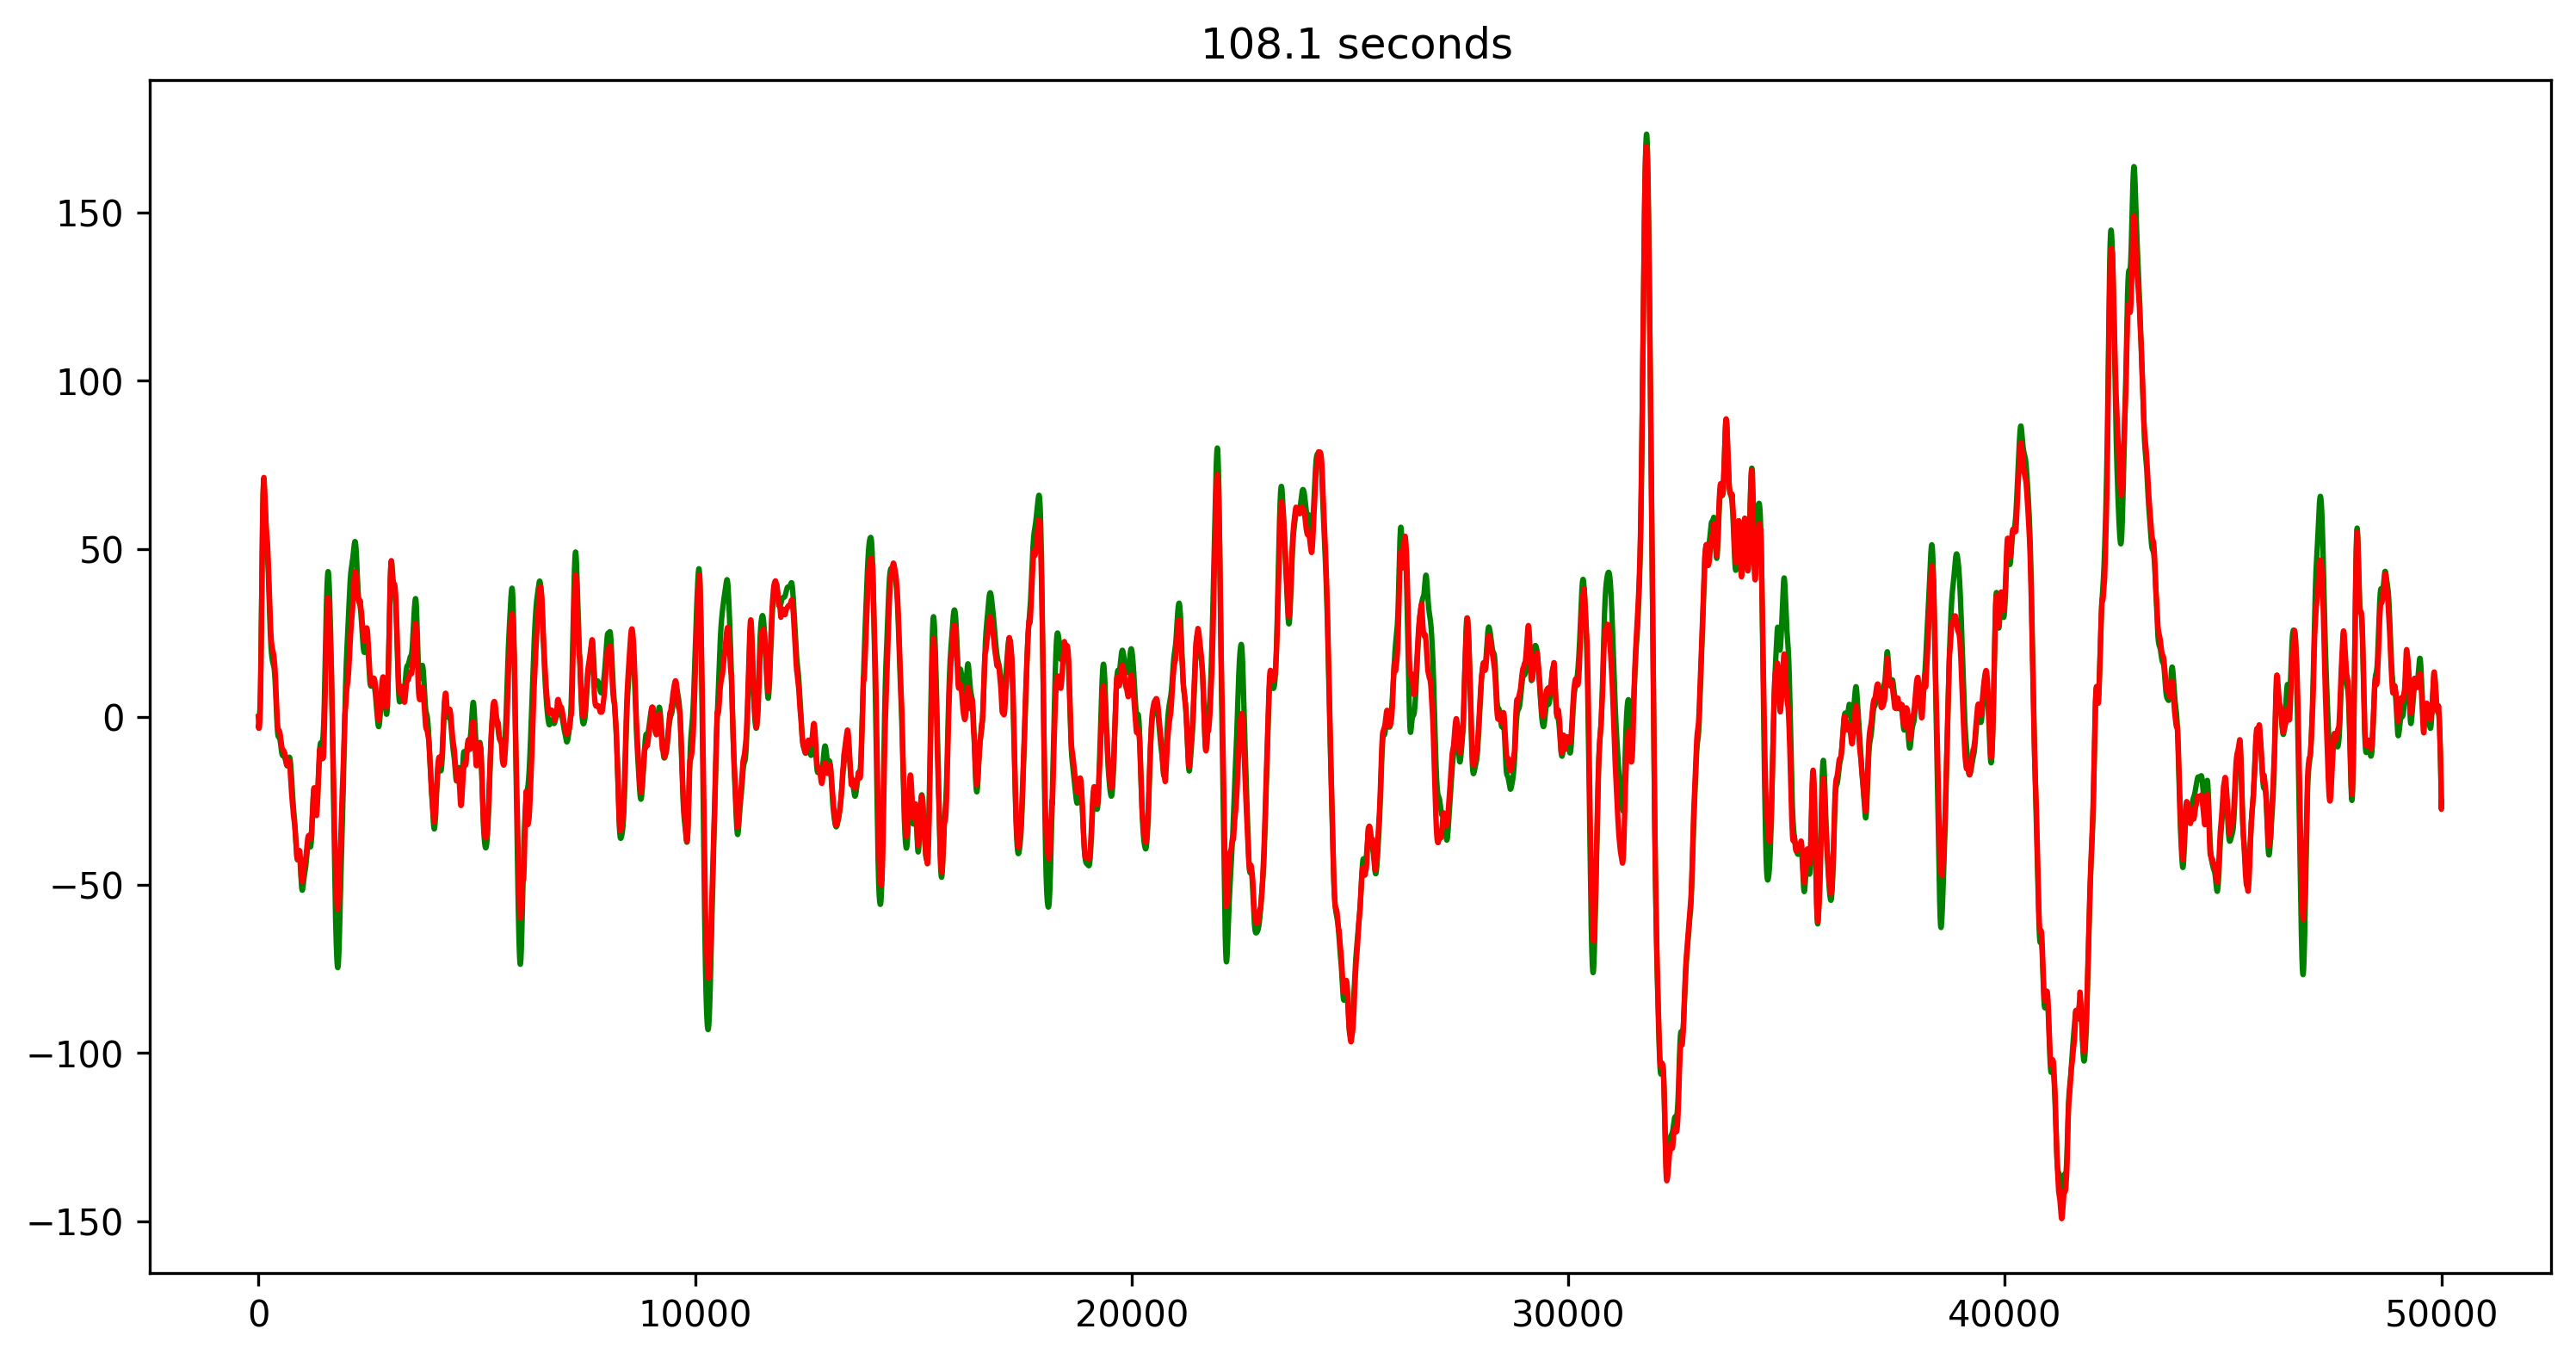

..................................................mse loss:  272.74442041015624


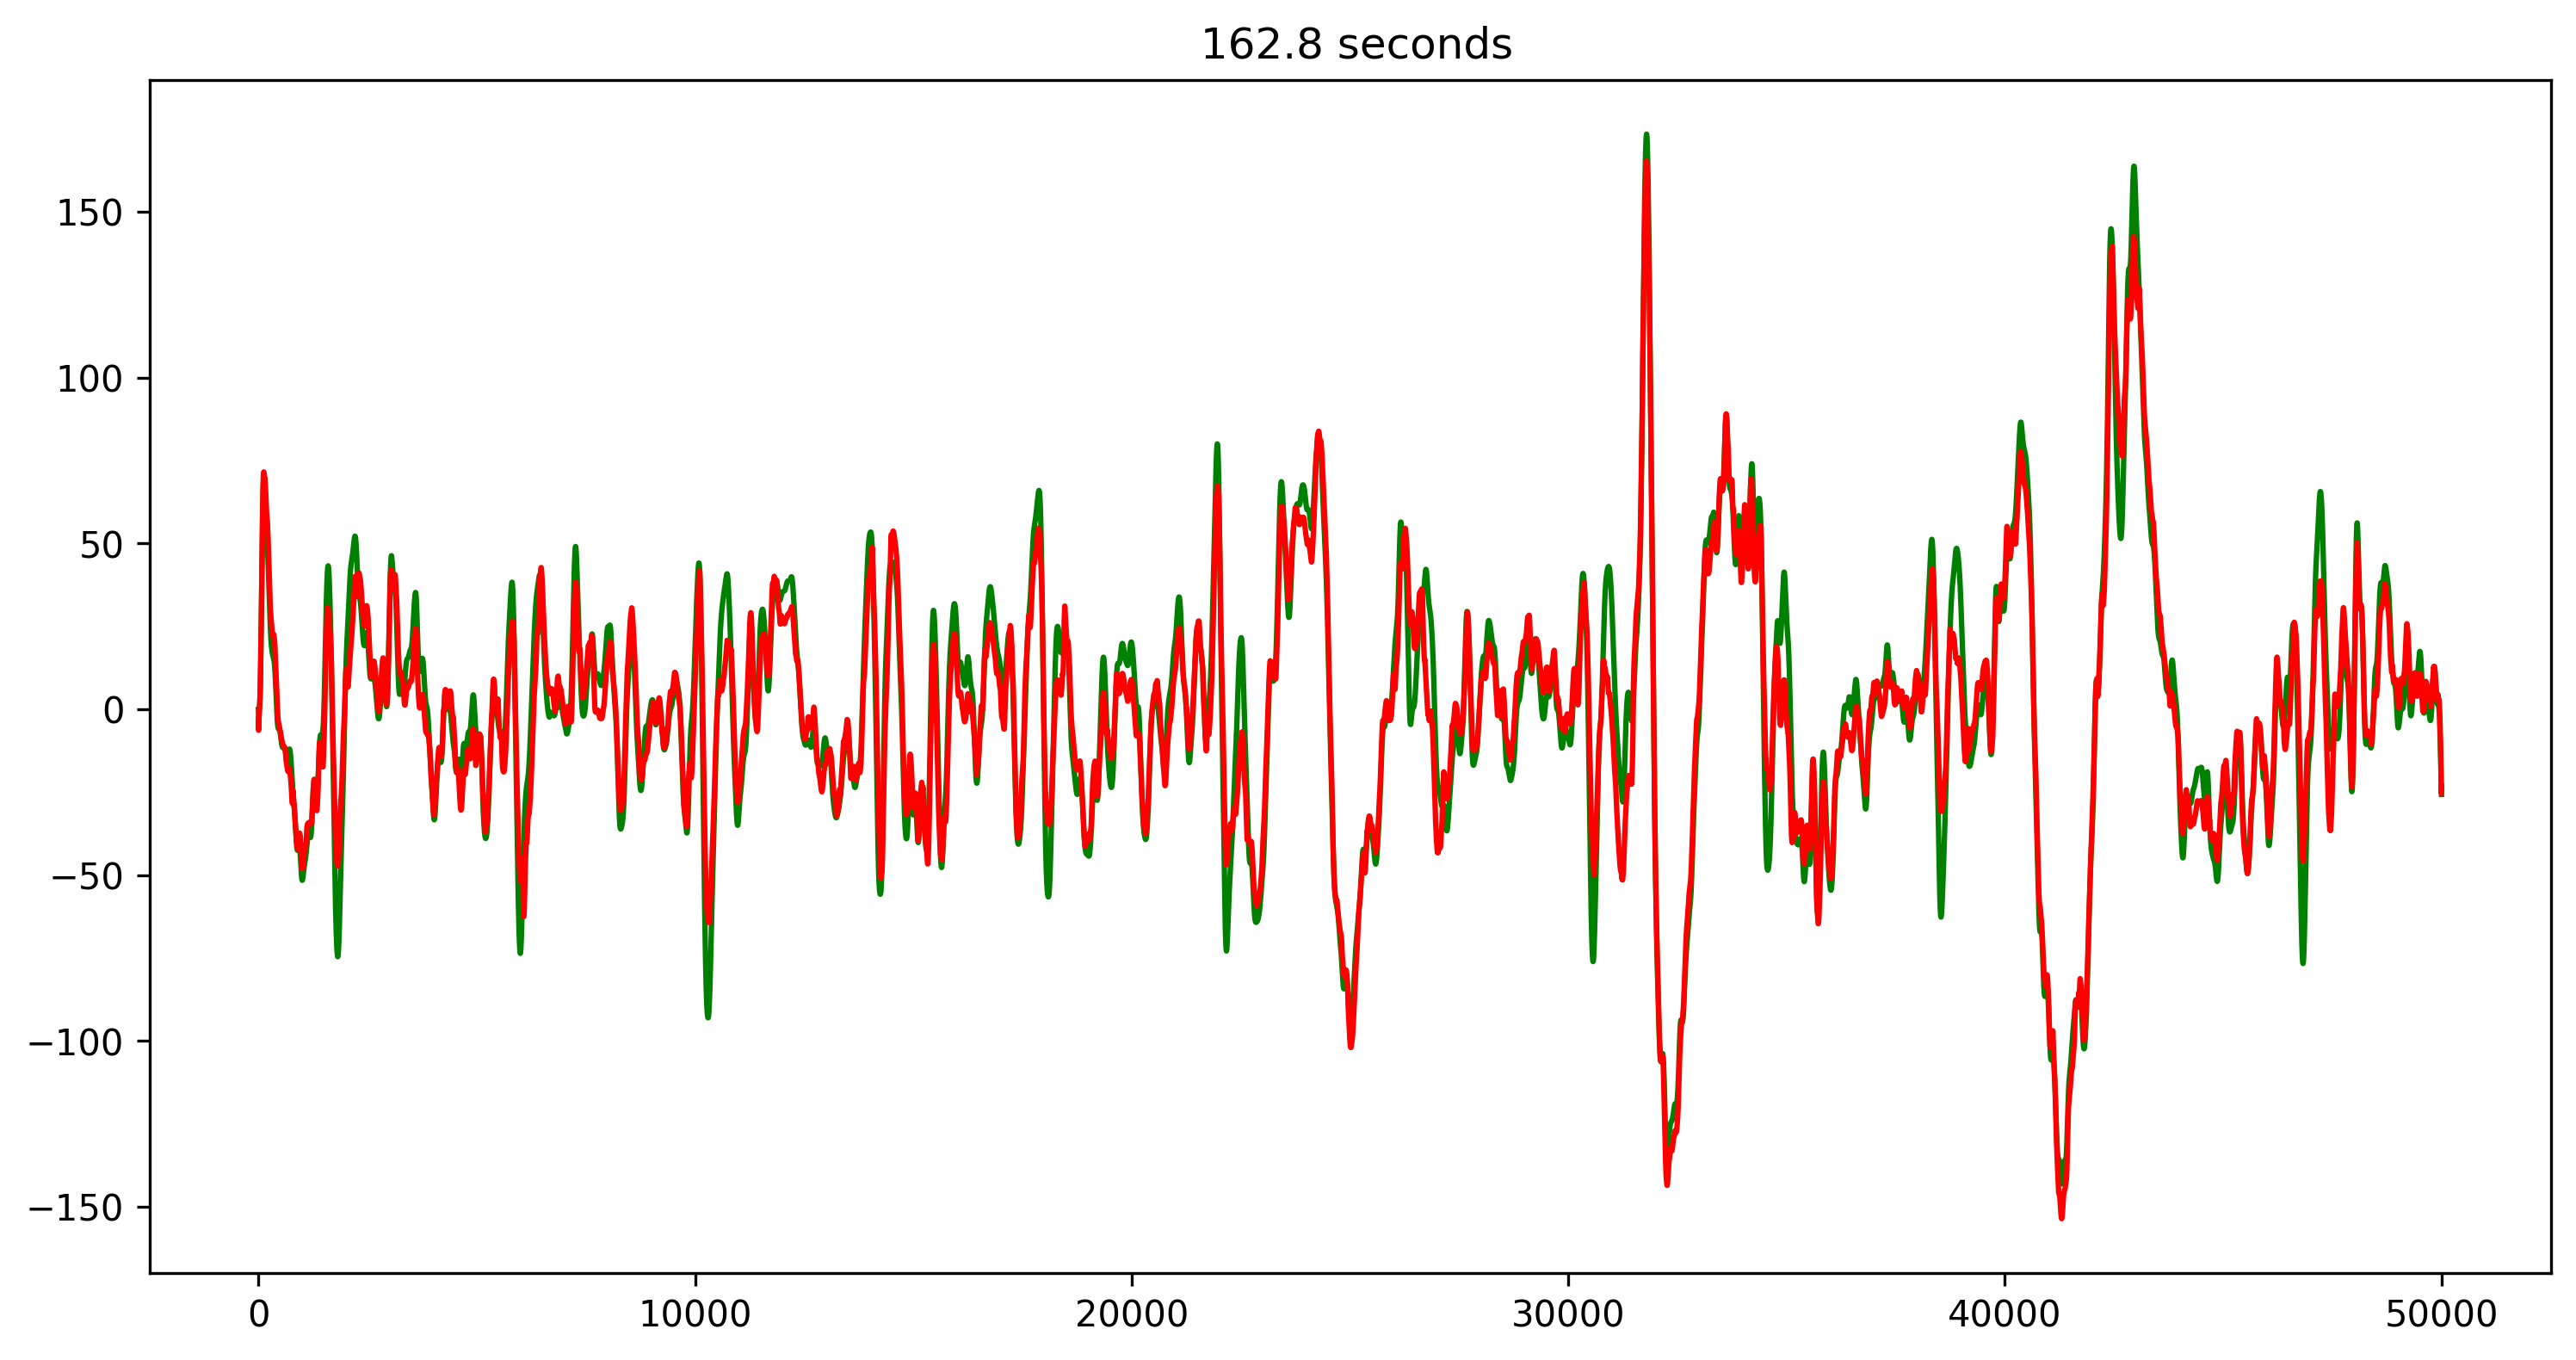

..................................................mse loss:  237.20804244995117


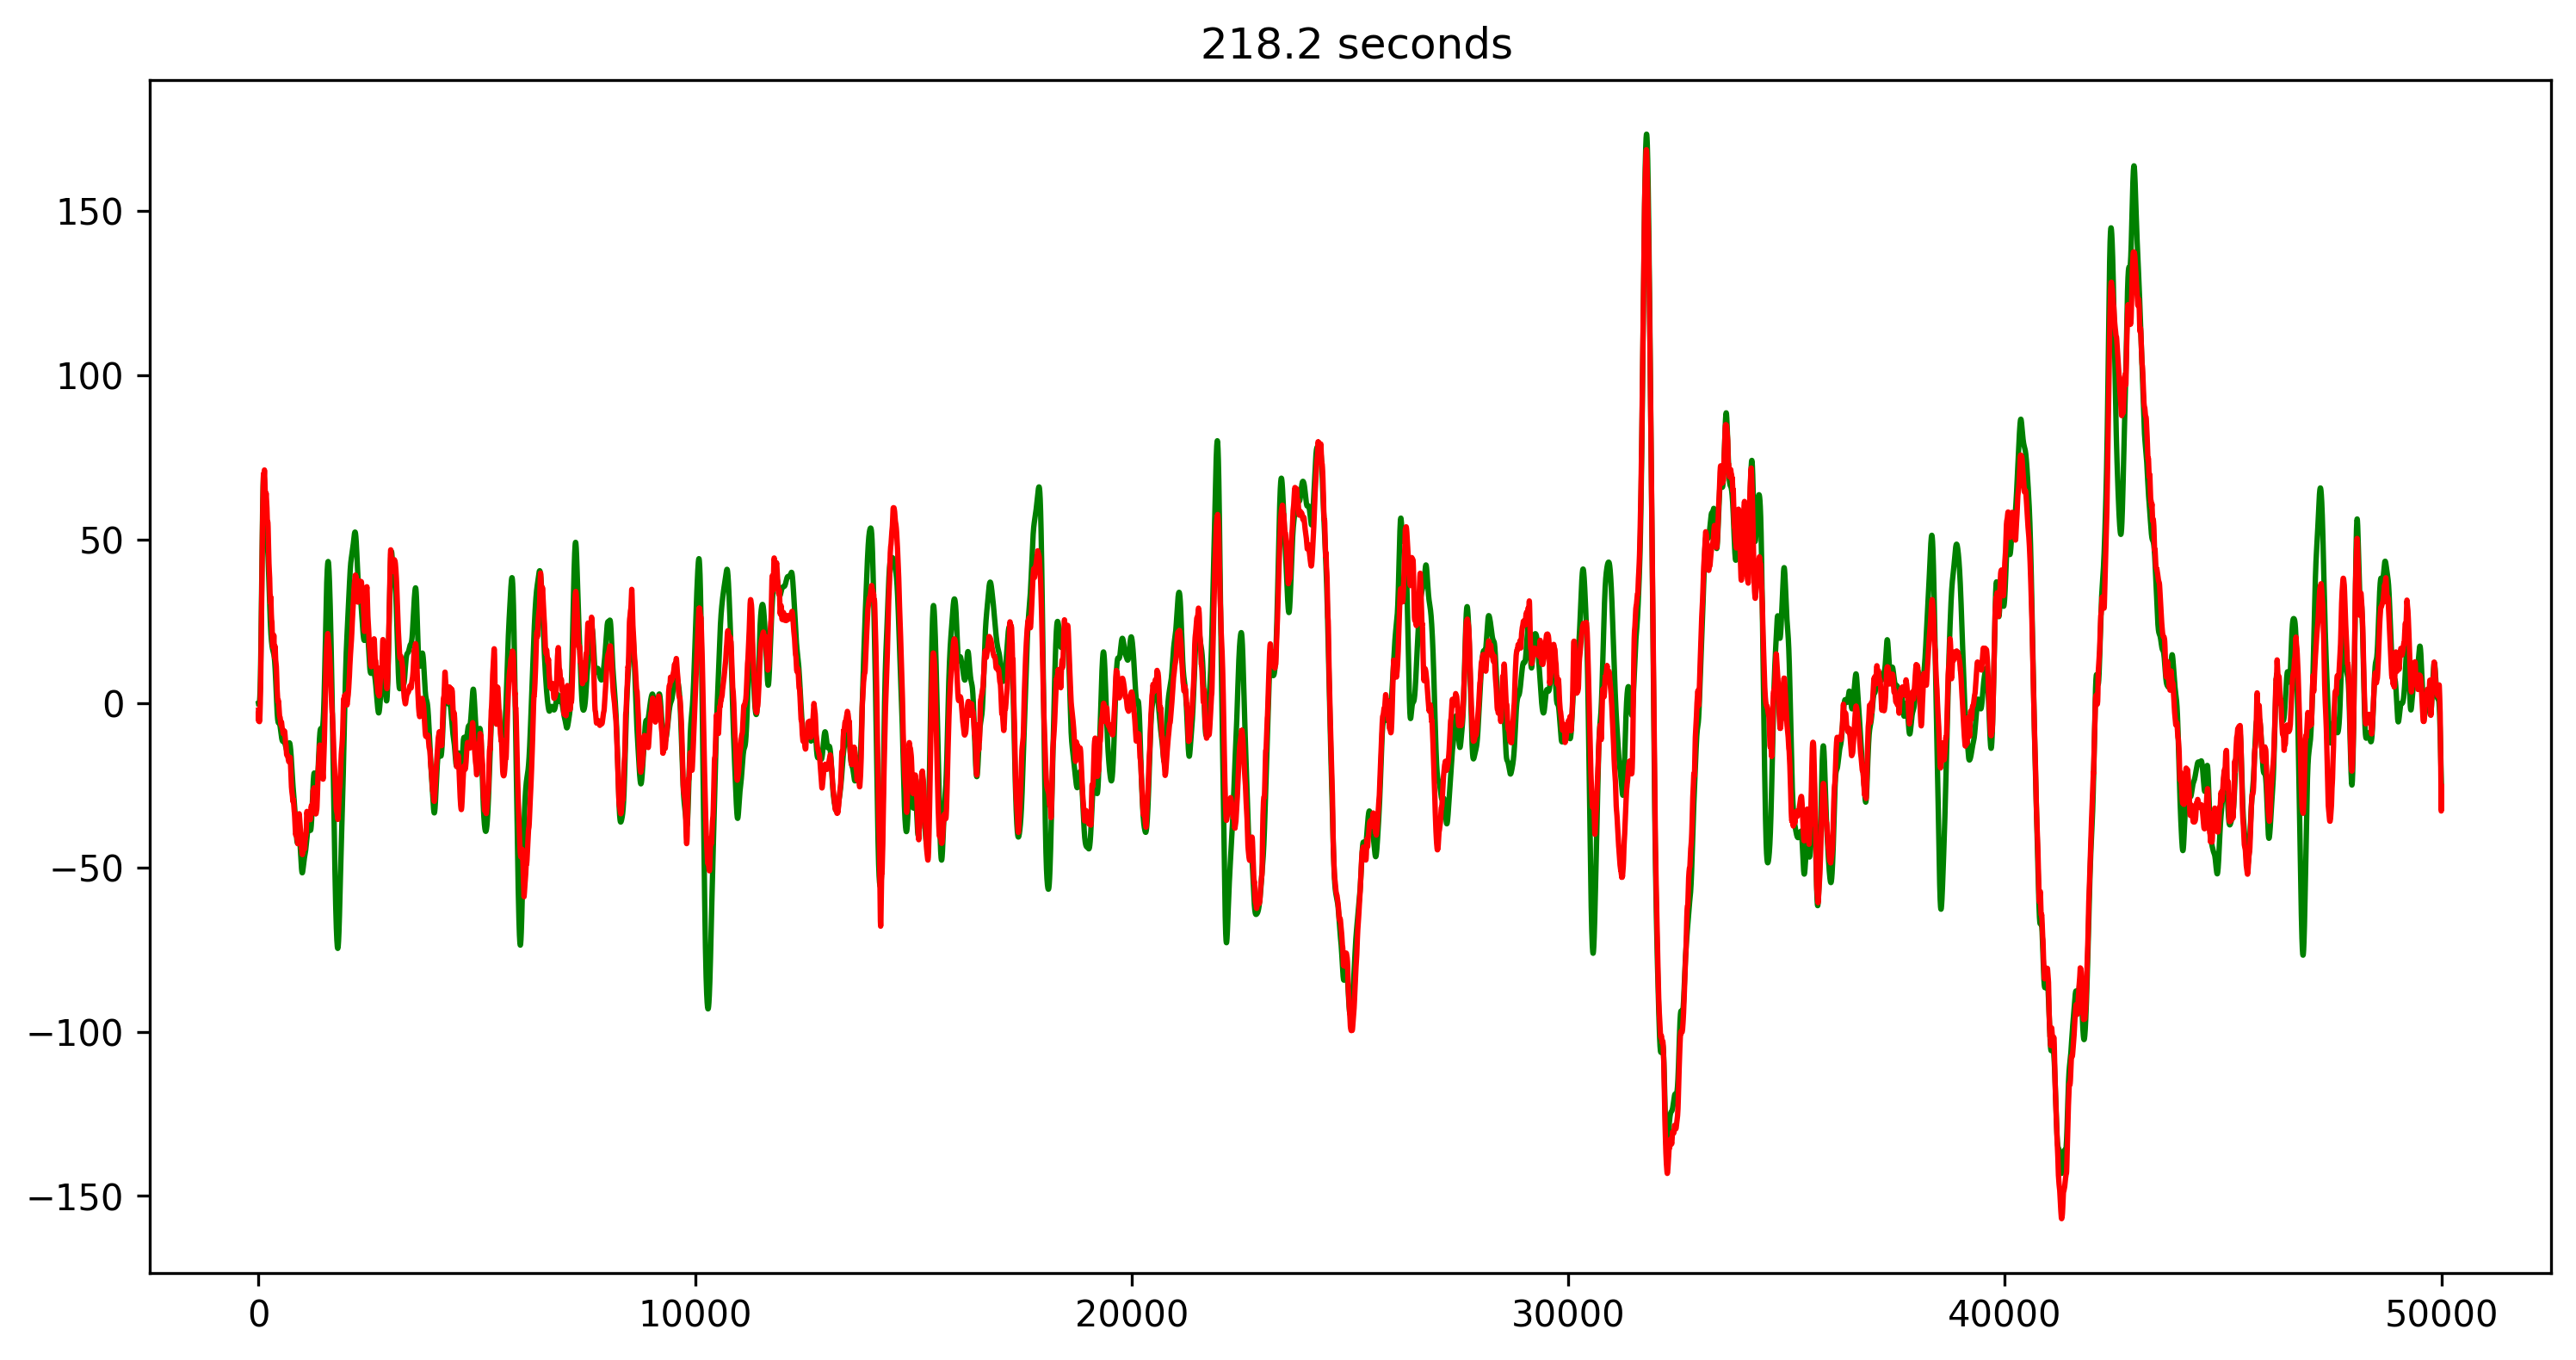

..................................................mse loss:  214.30851174926758


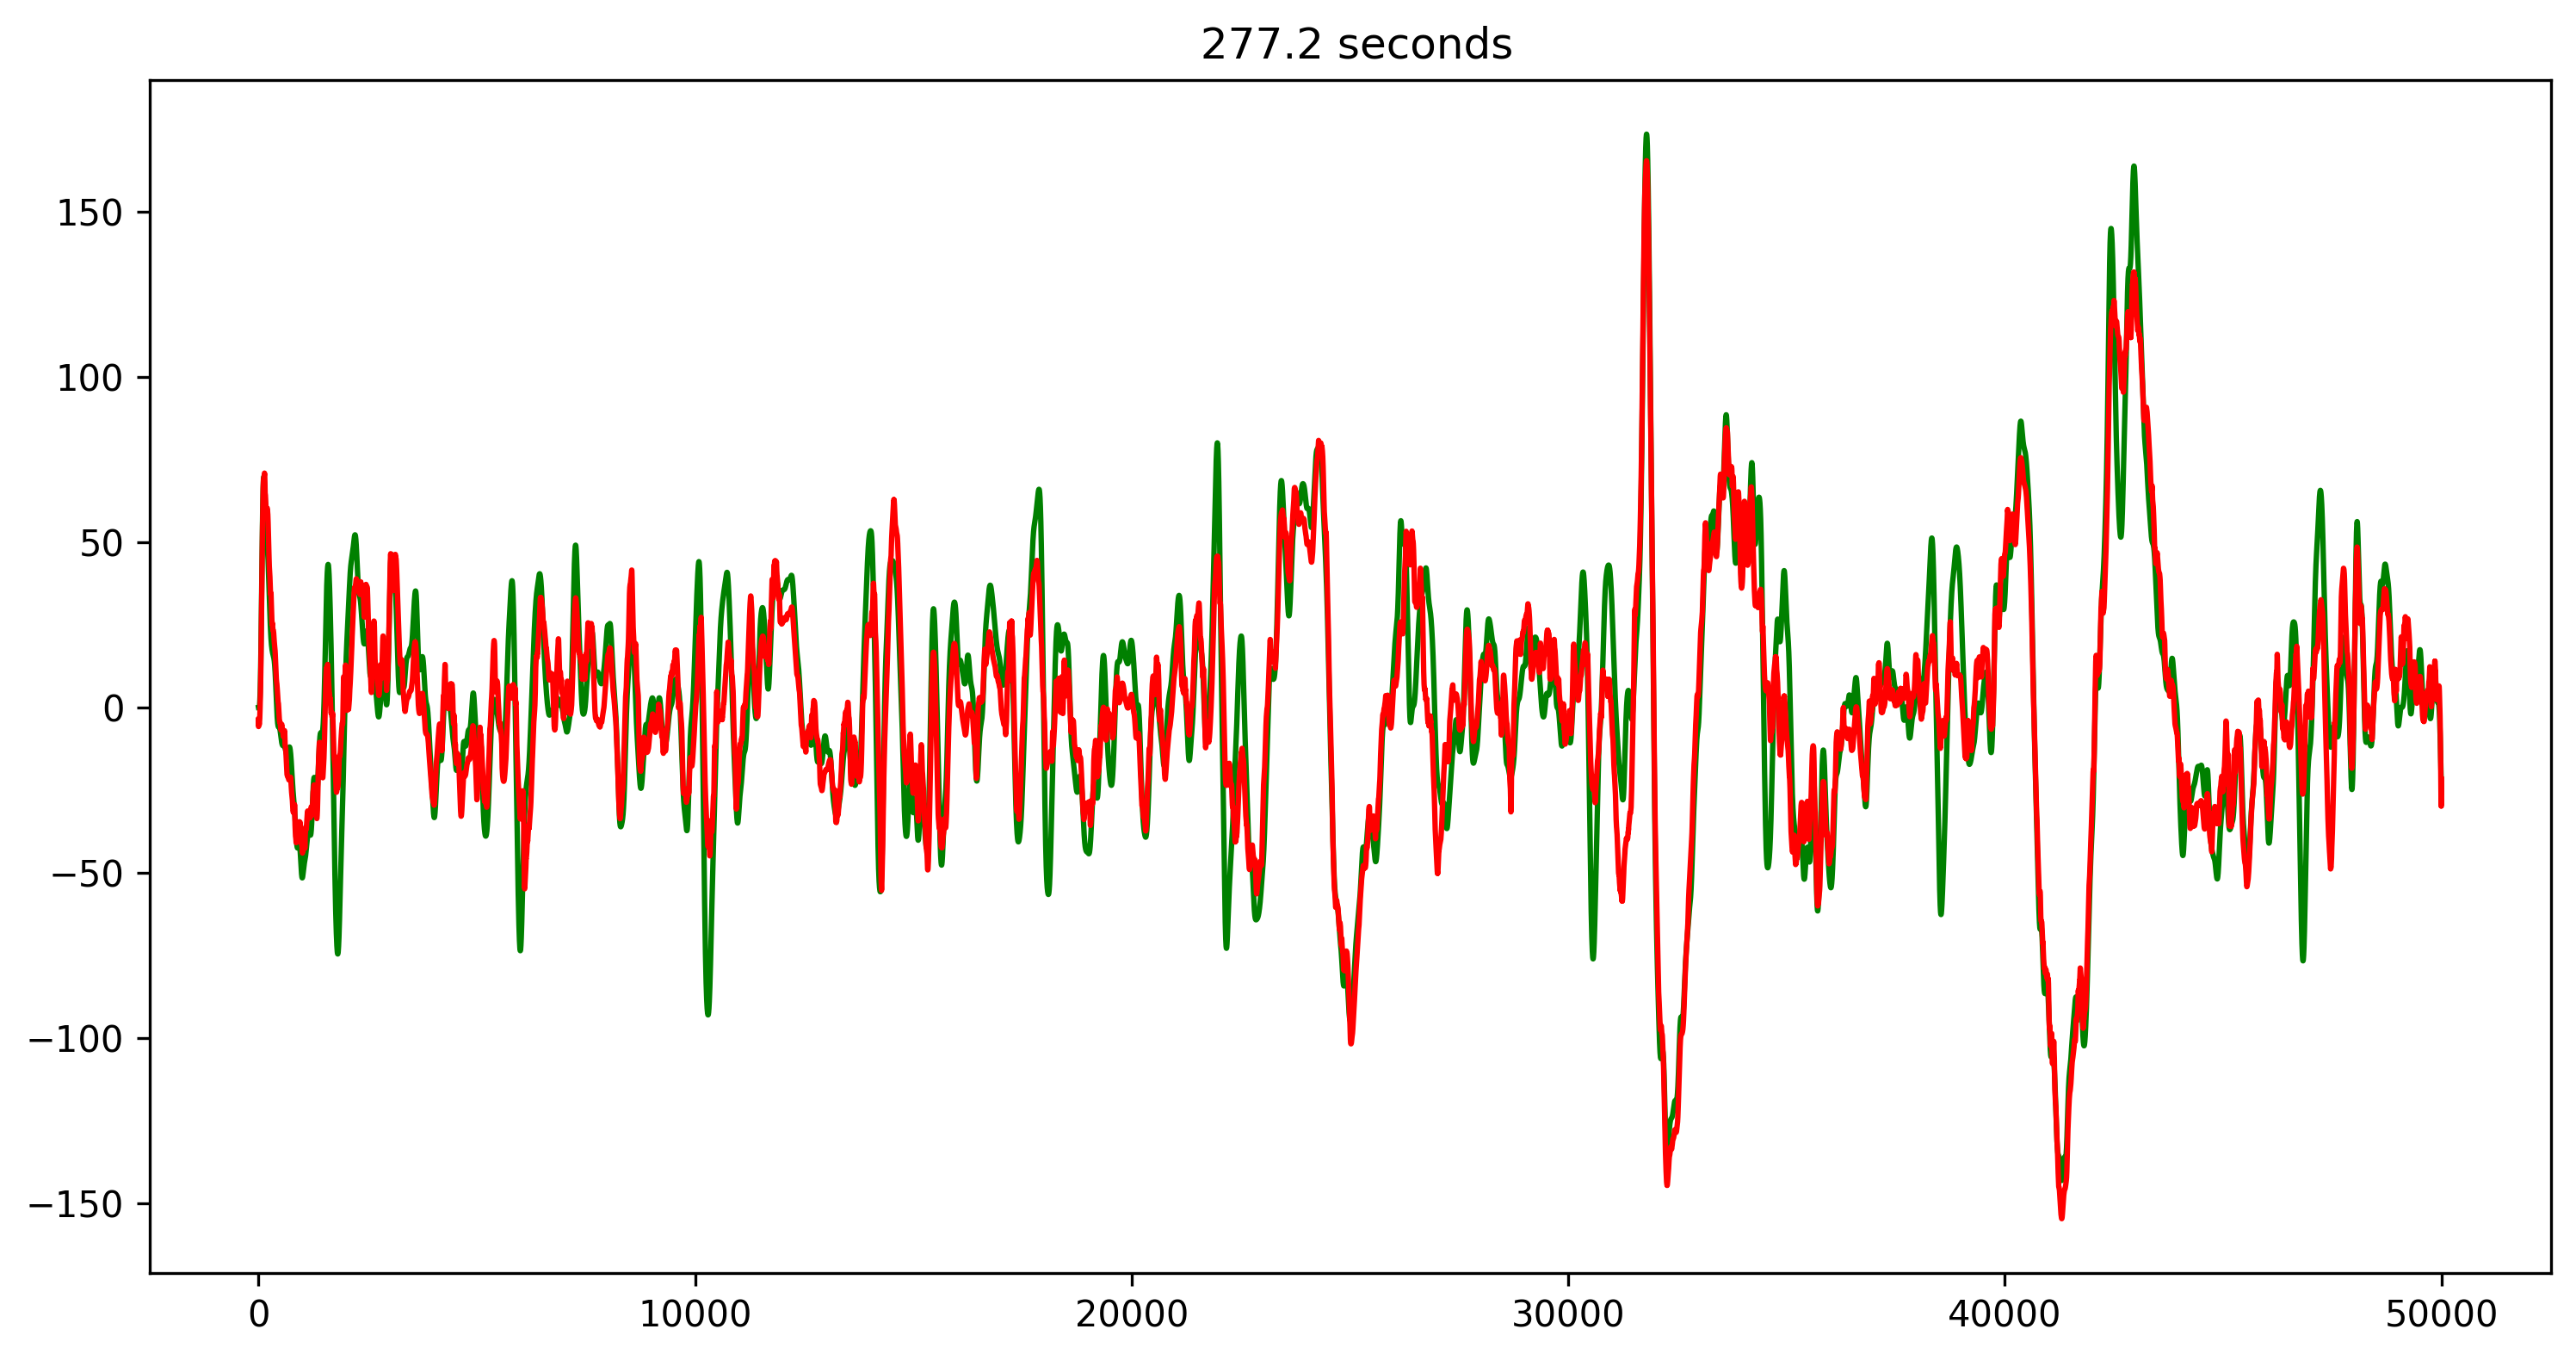

..................................................mse loss:  197.17184274291992


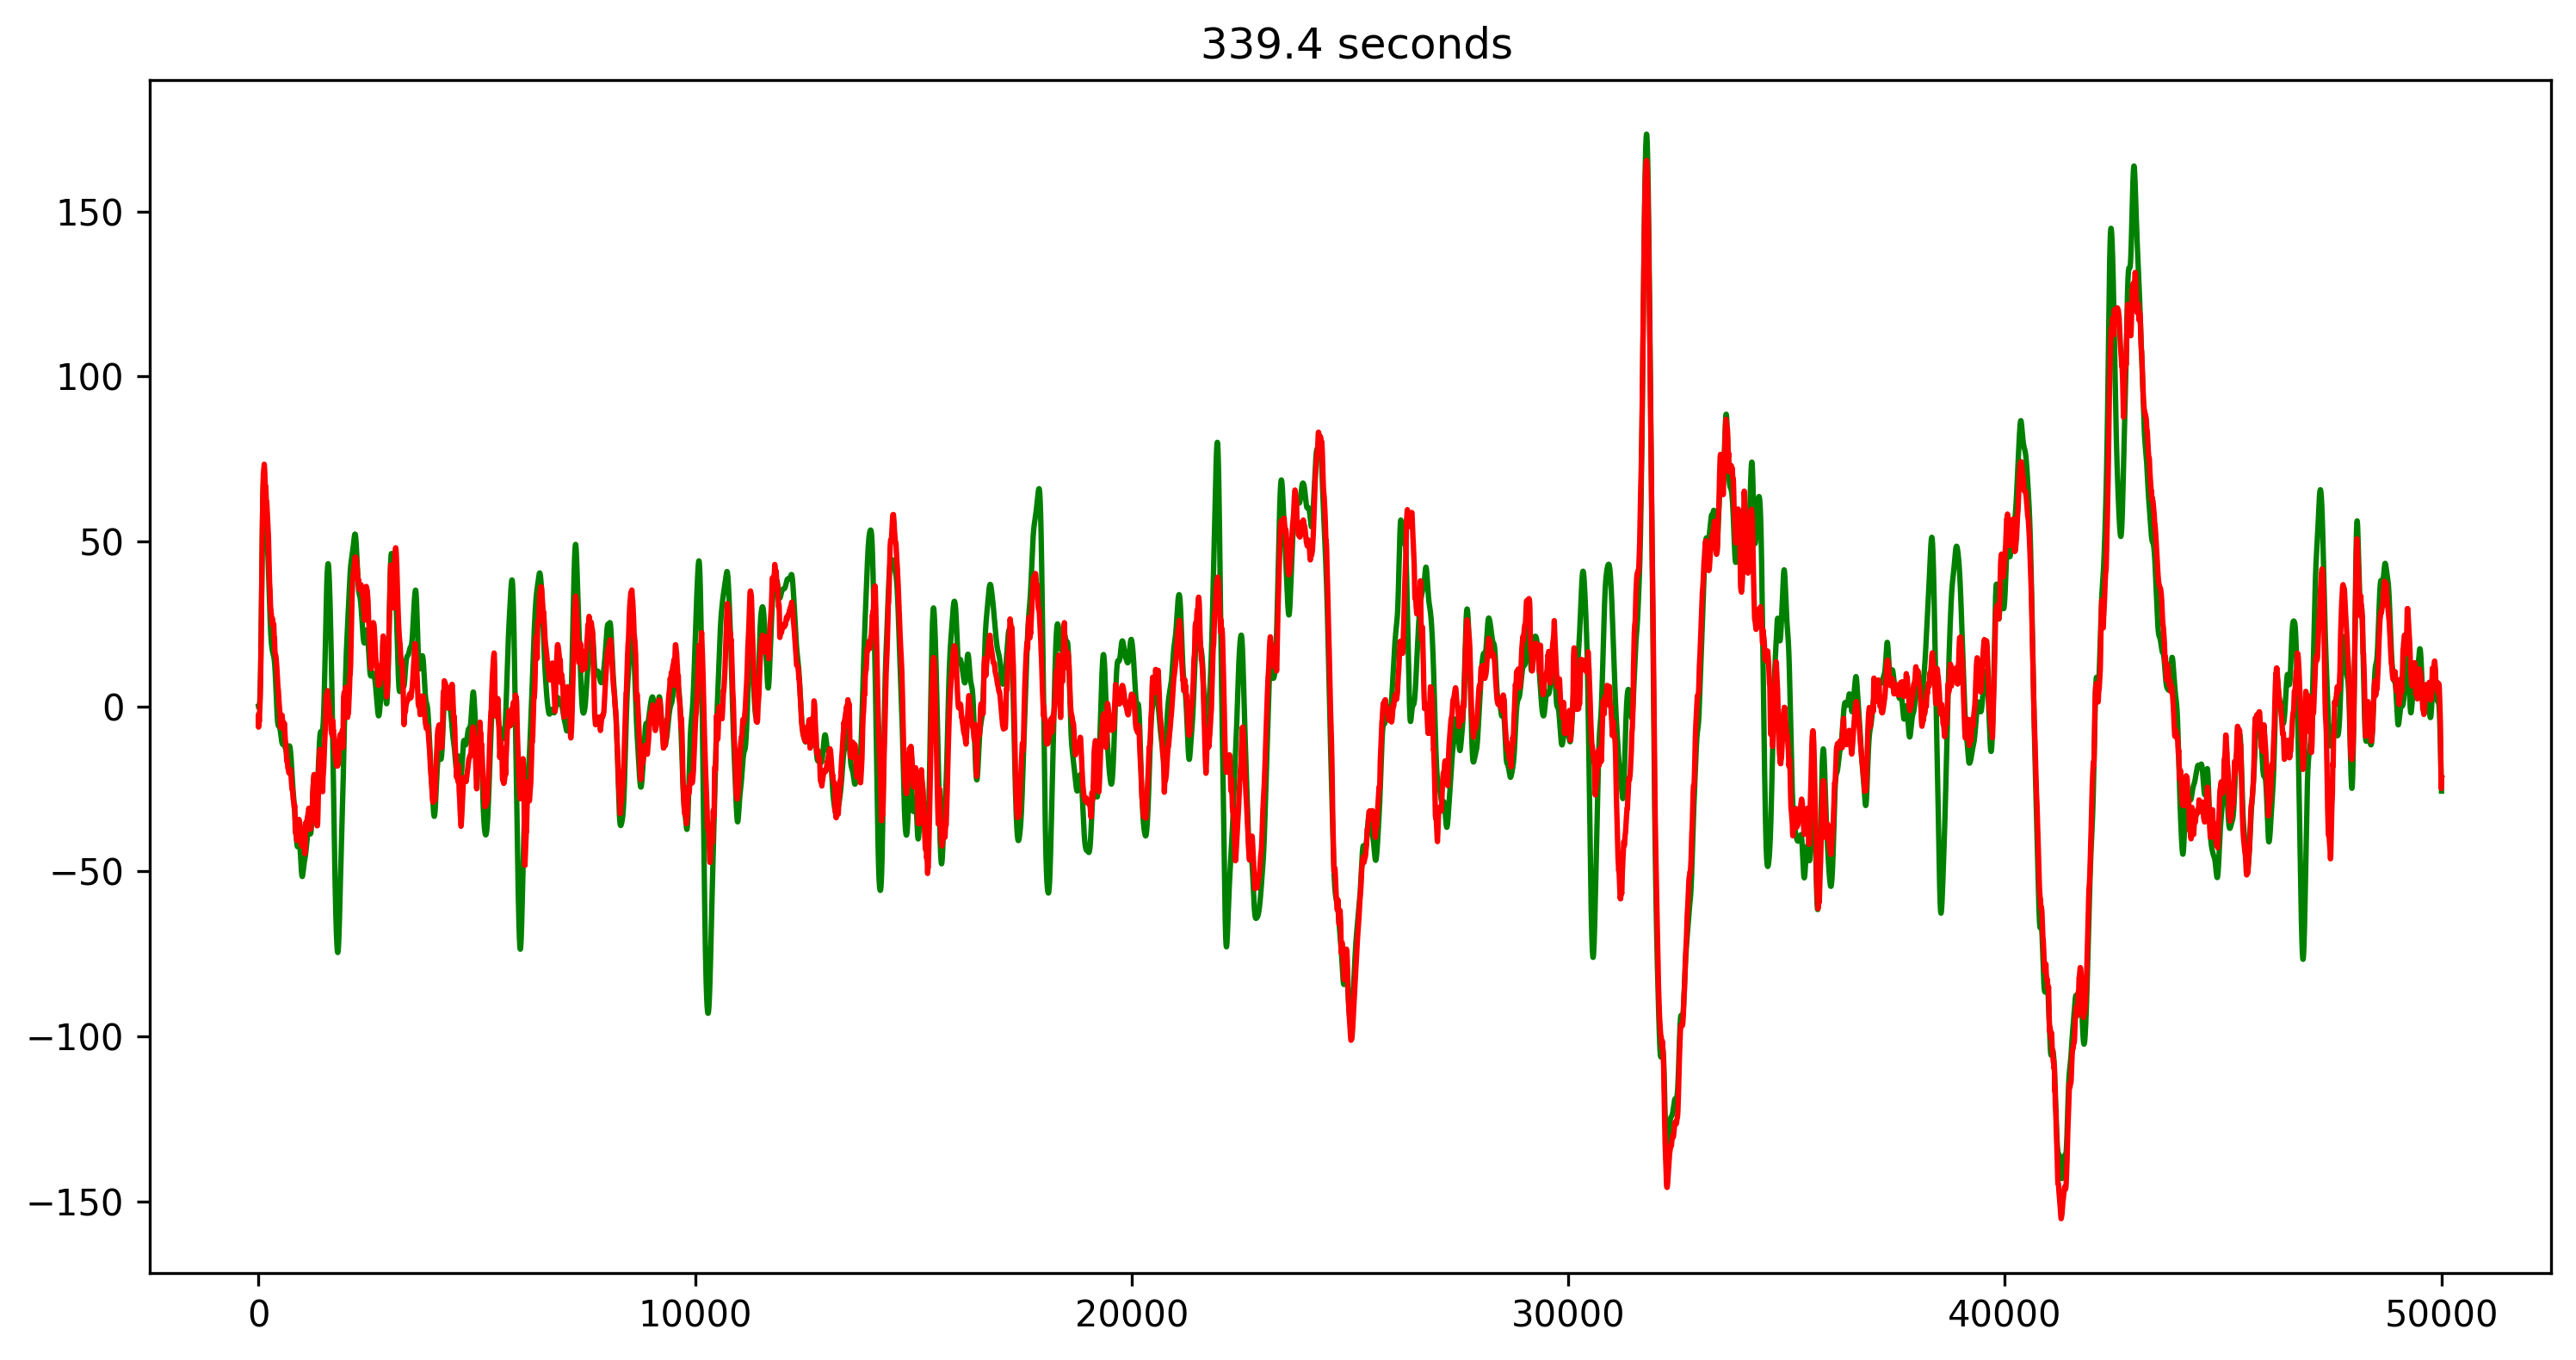

..................................................mse loss:  182.6043814239502


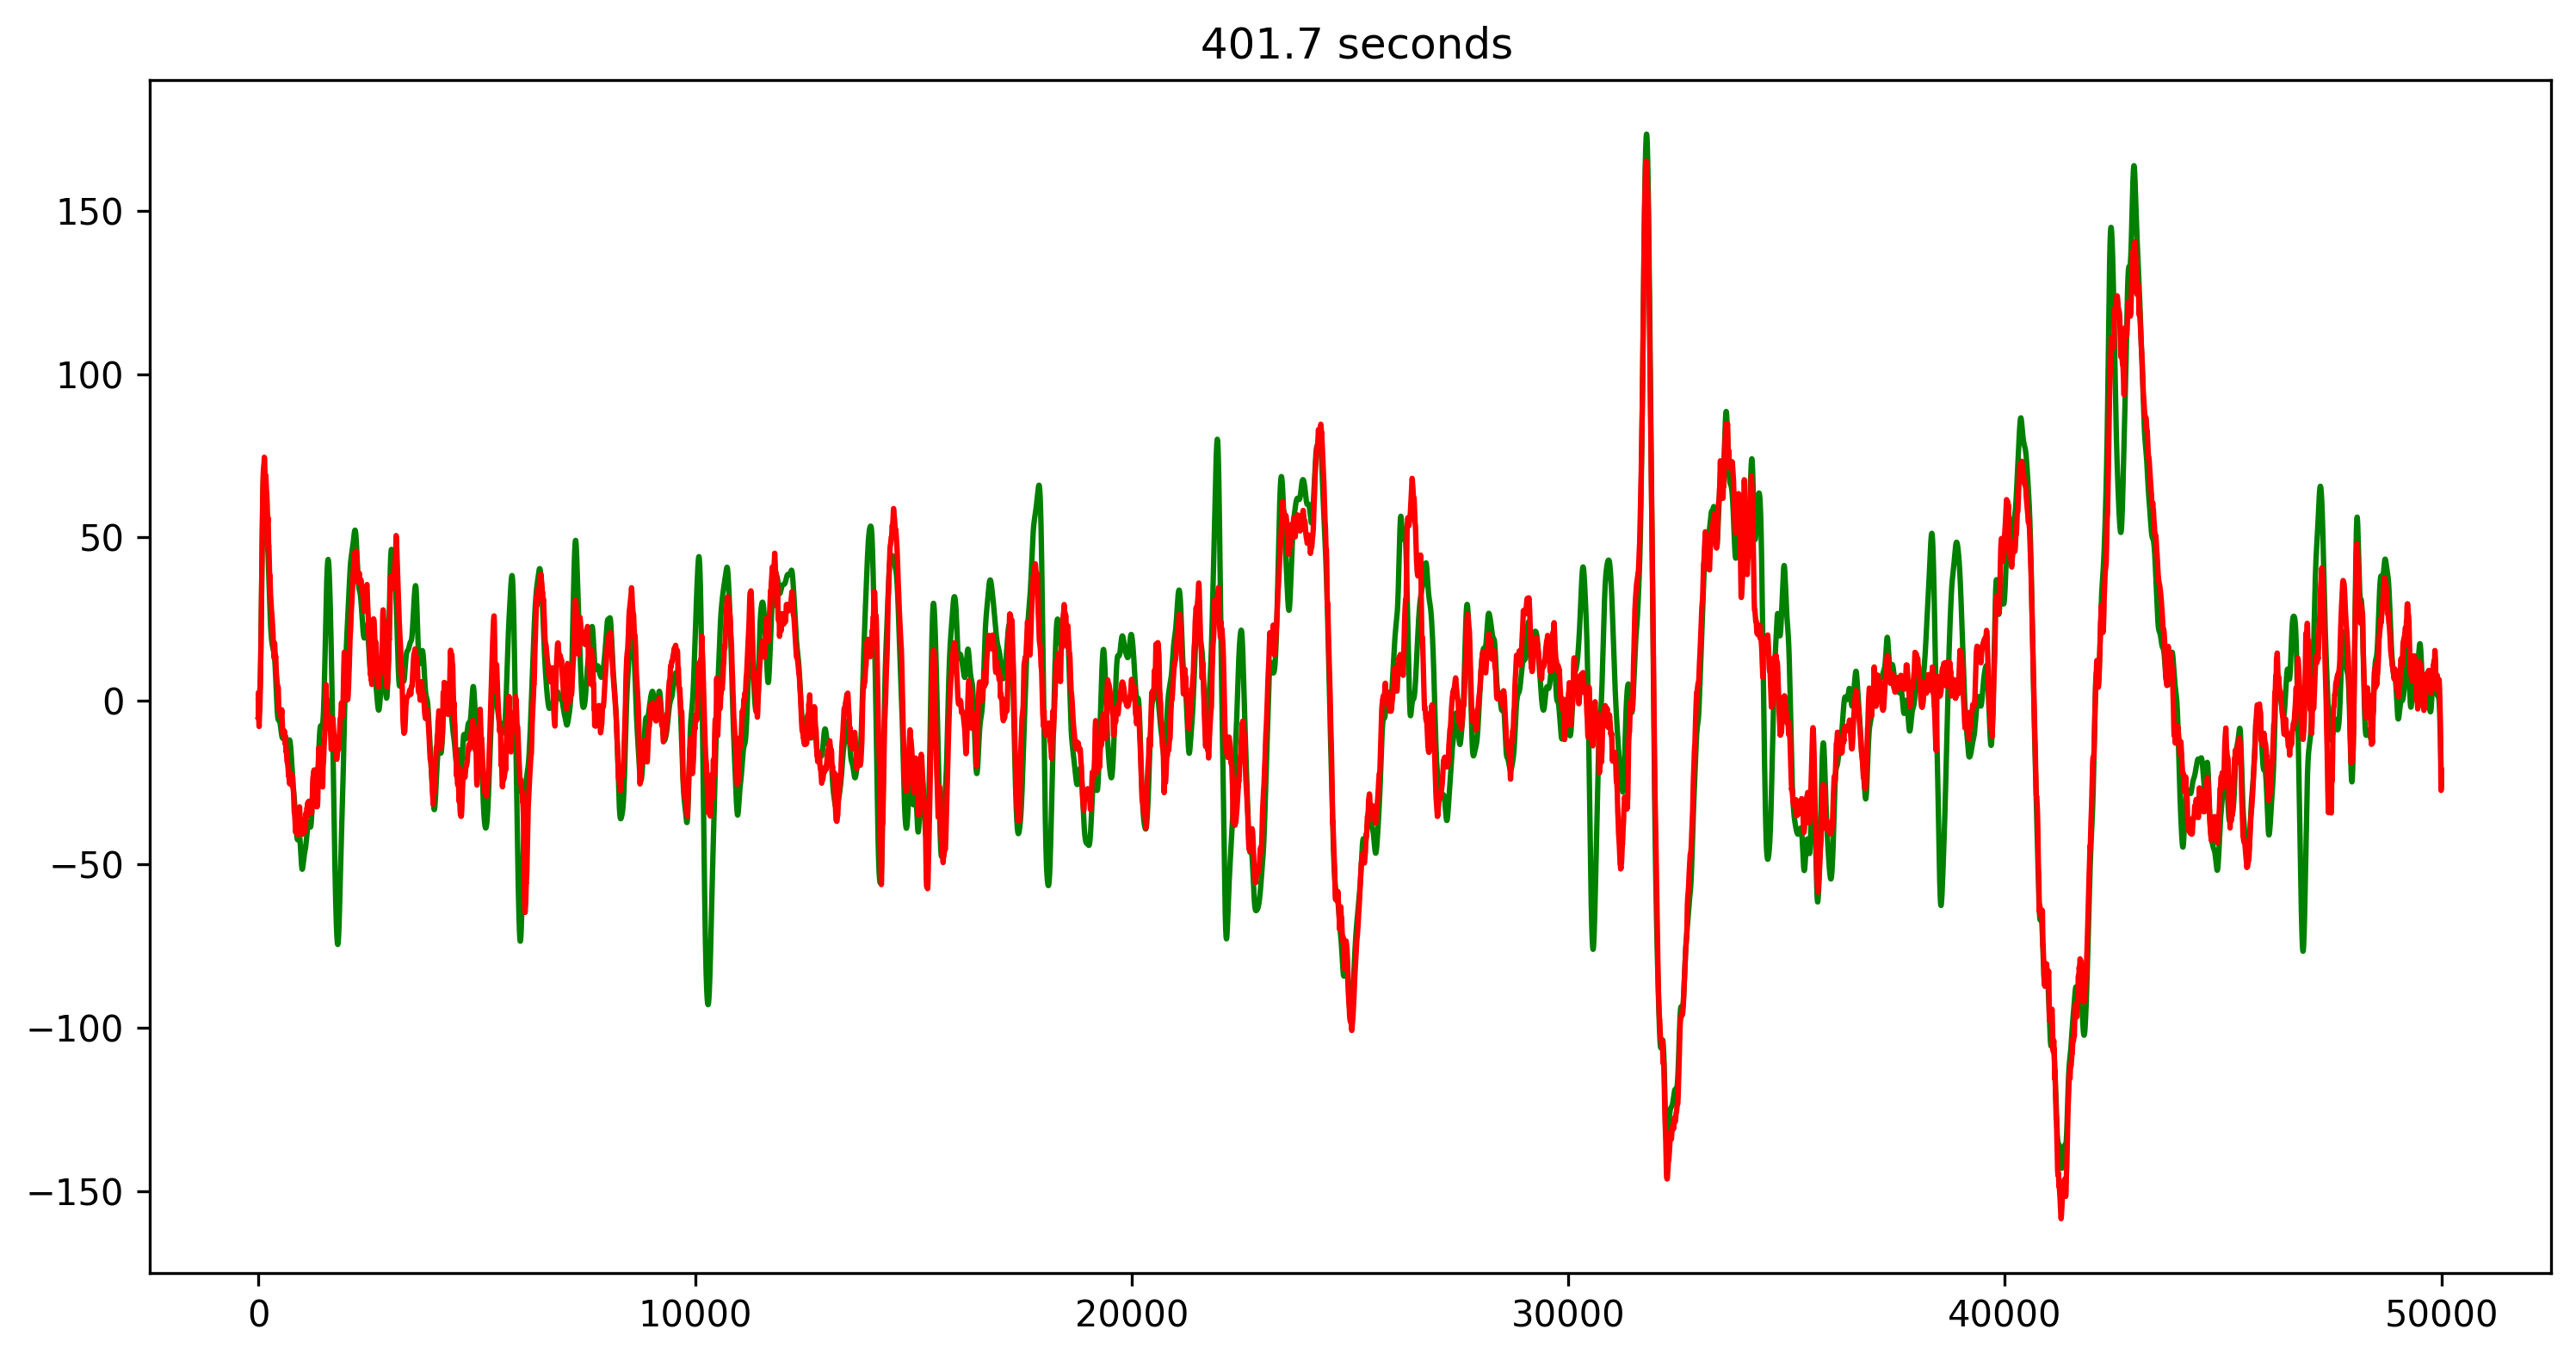

..................................................mse loss:  169.47323770141602


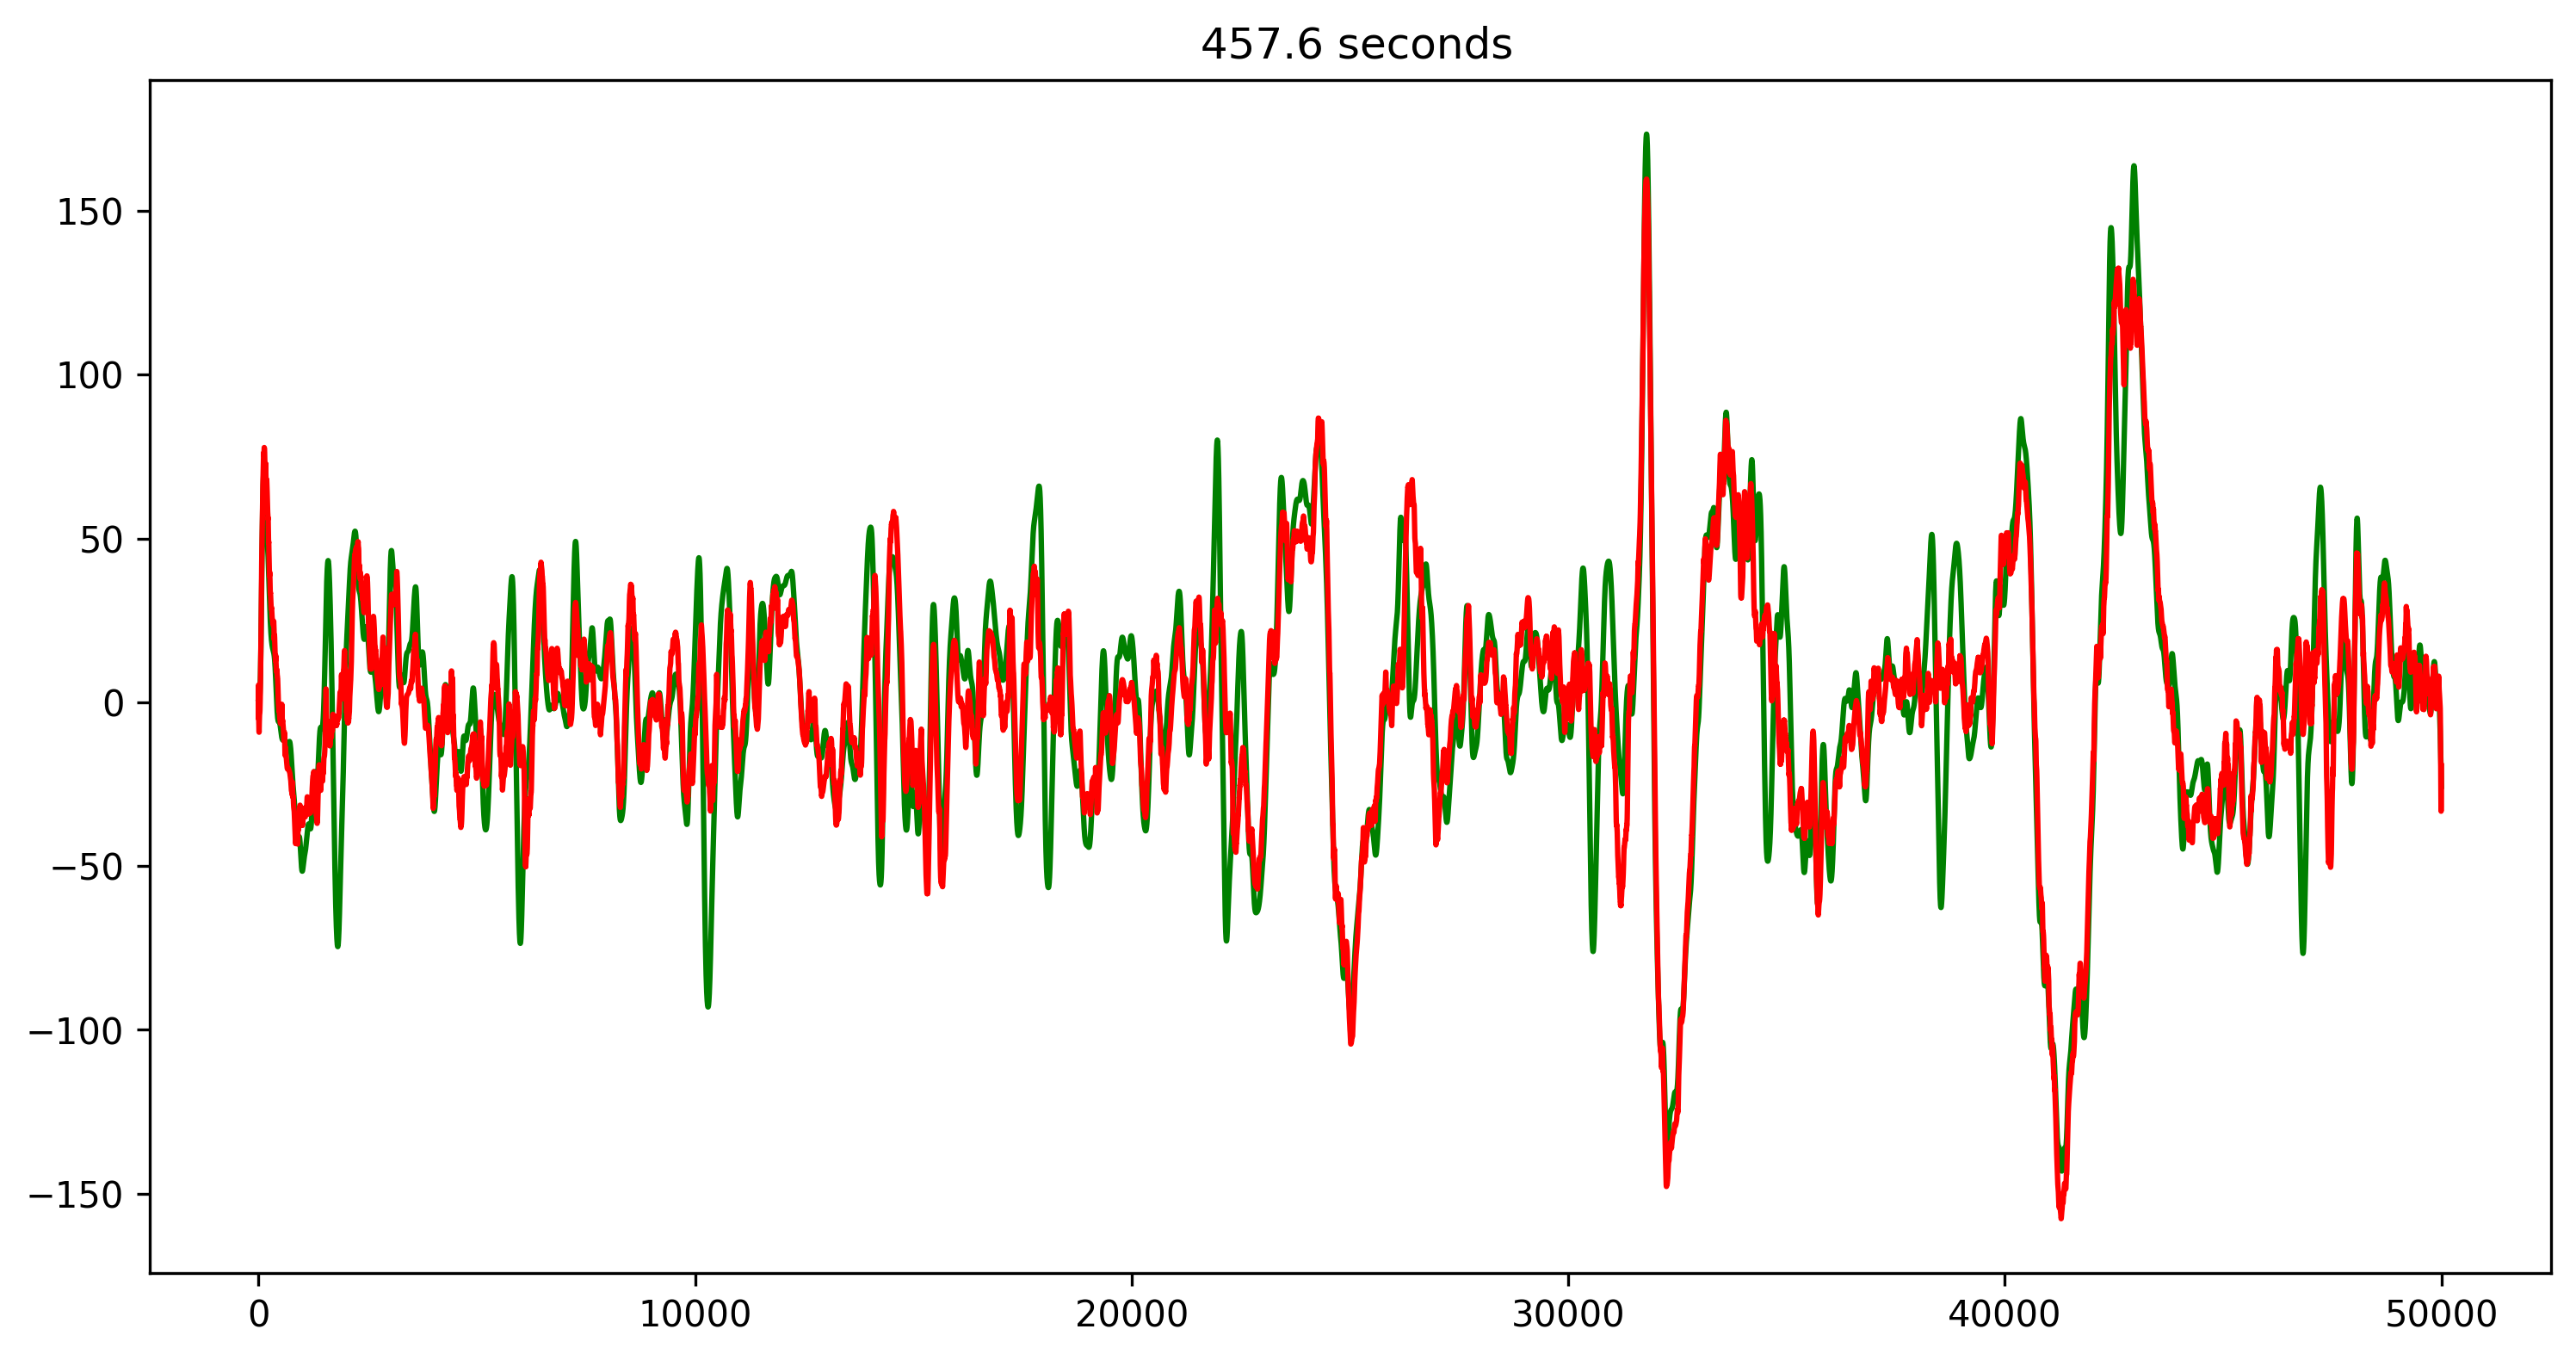

..................................................mse loss:  166.0630890197754


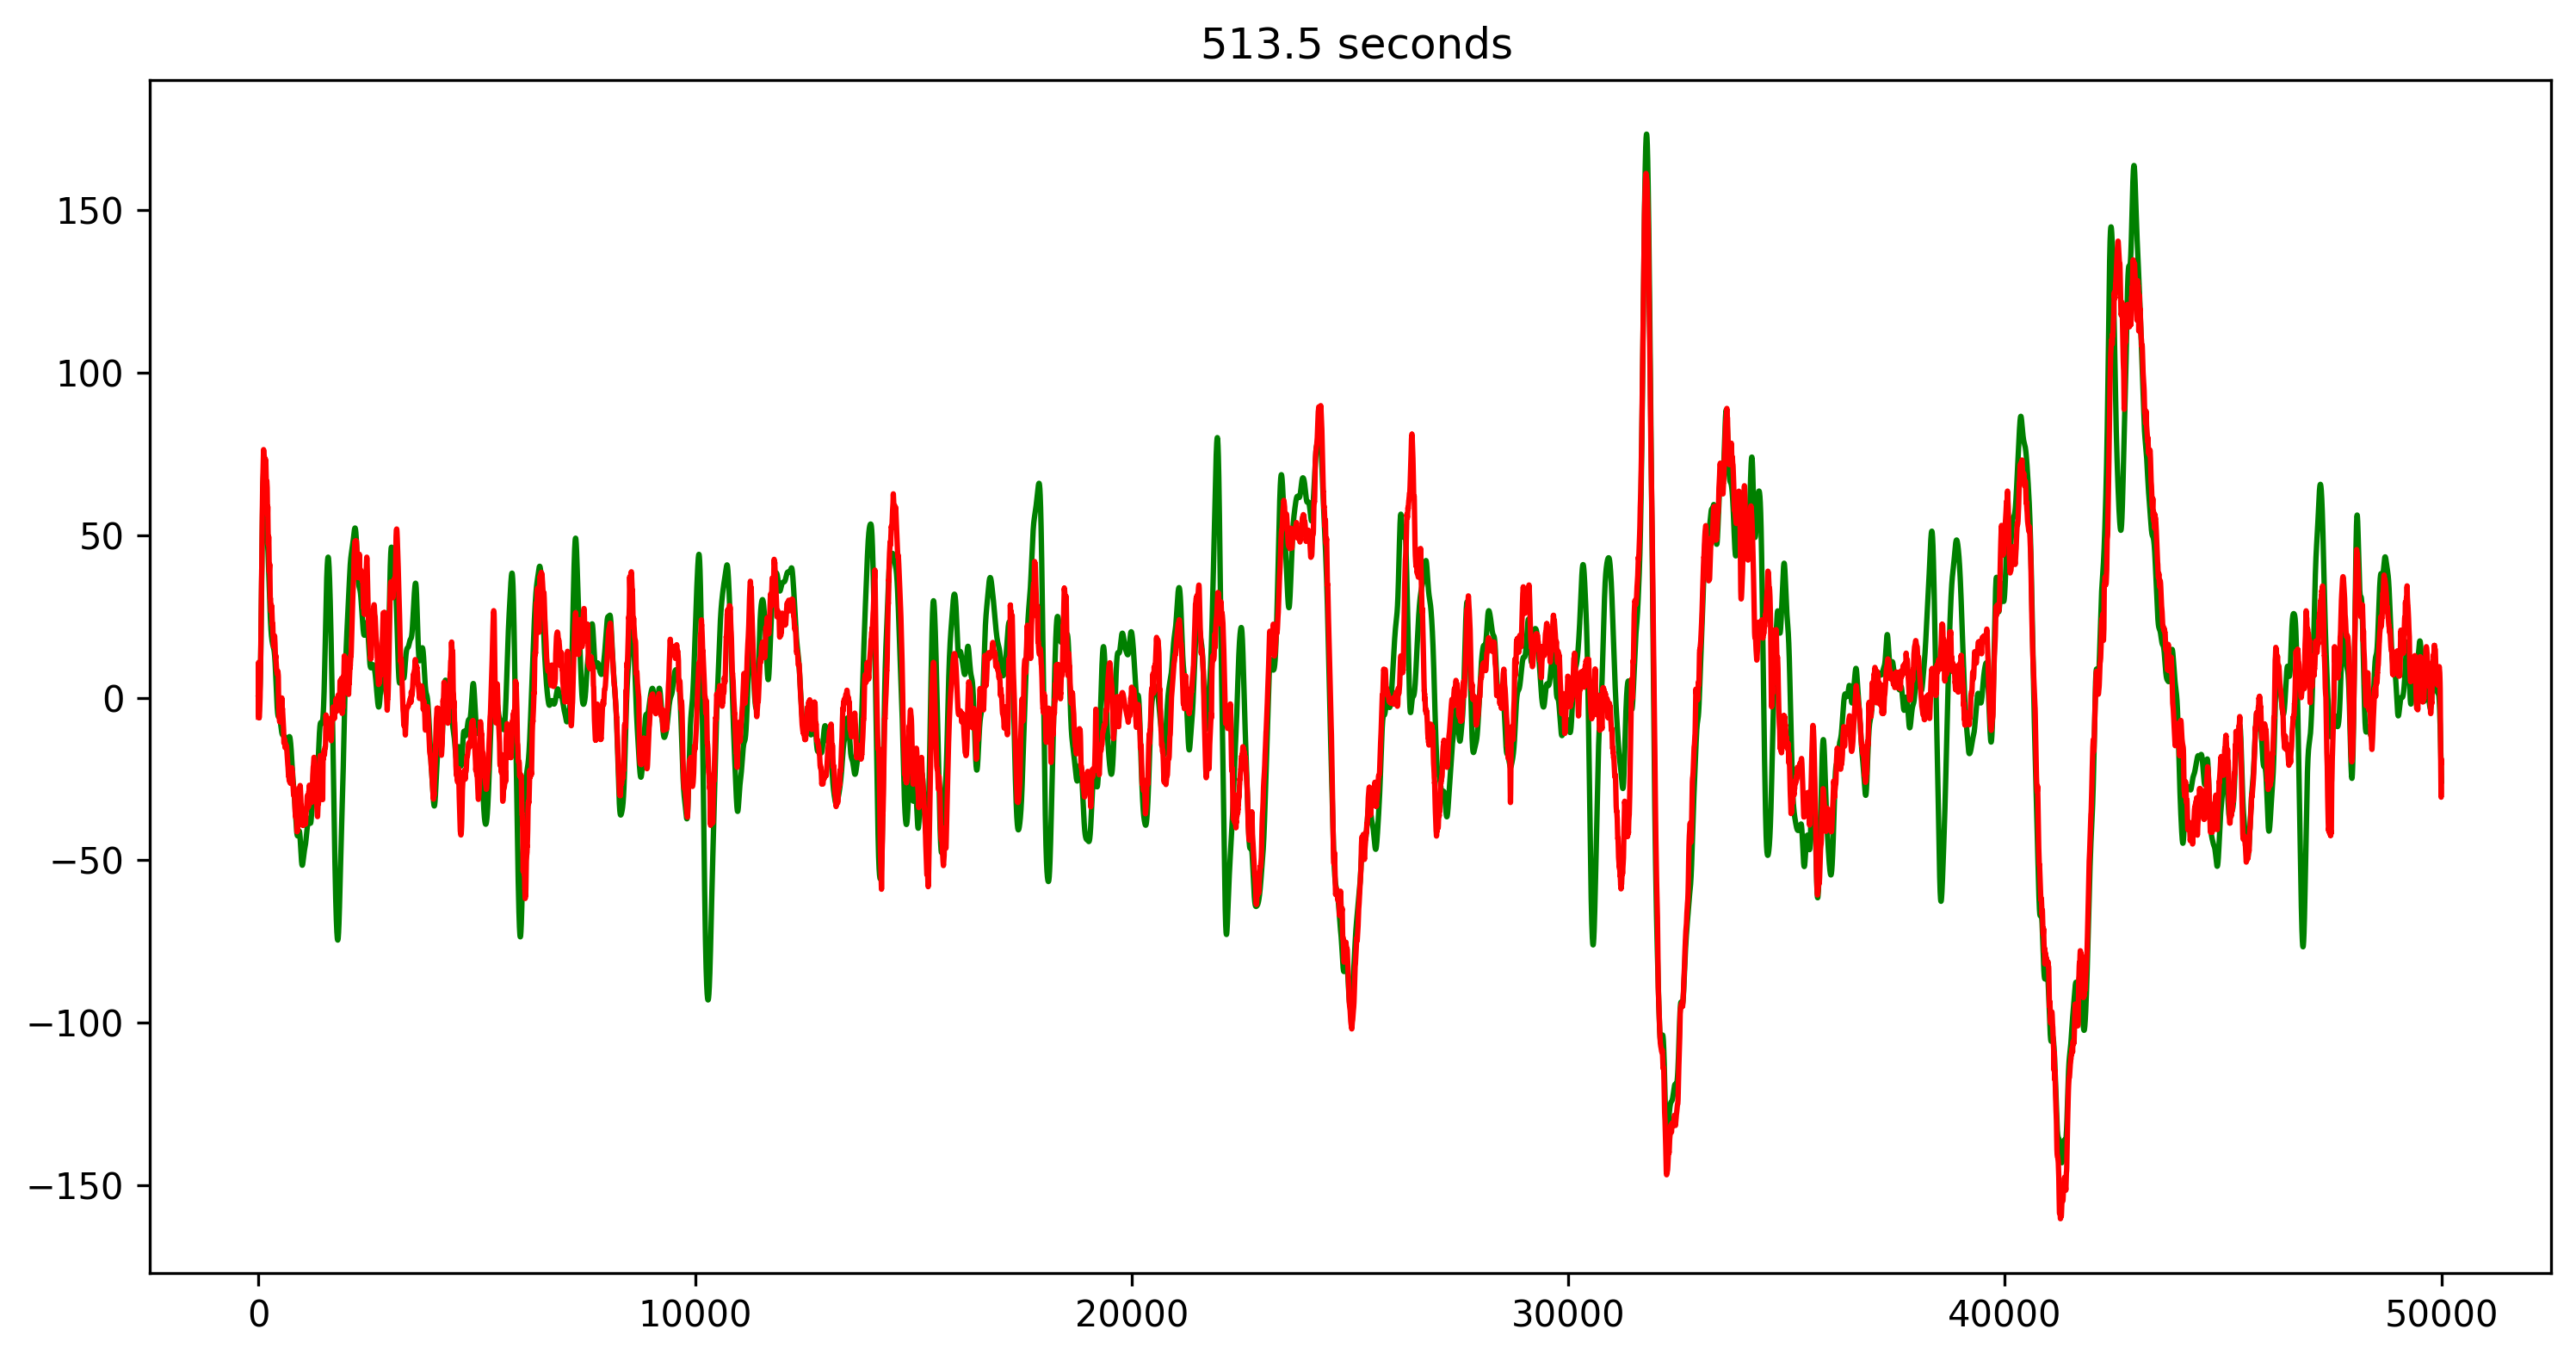

..................................................mse loss:  164.38400225830077


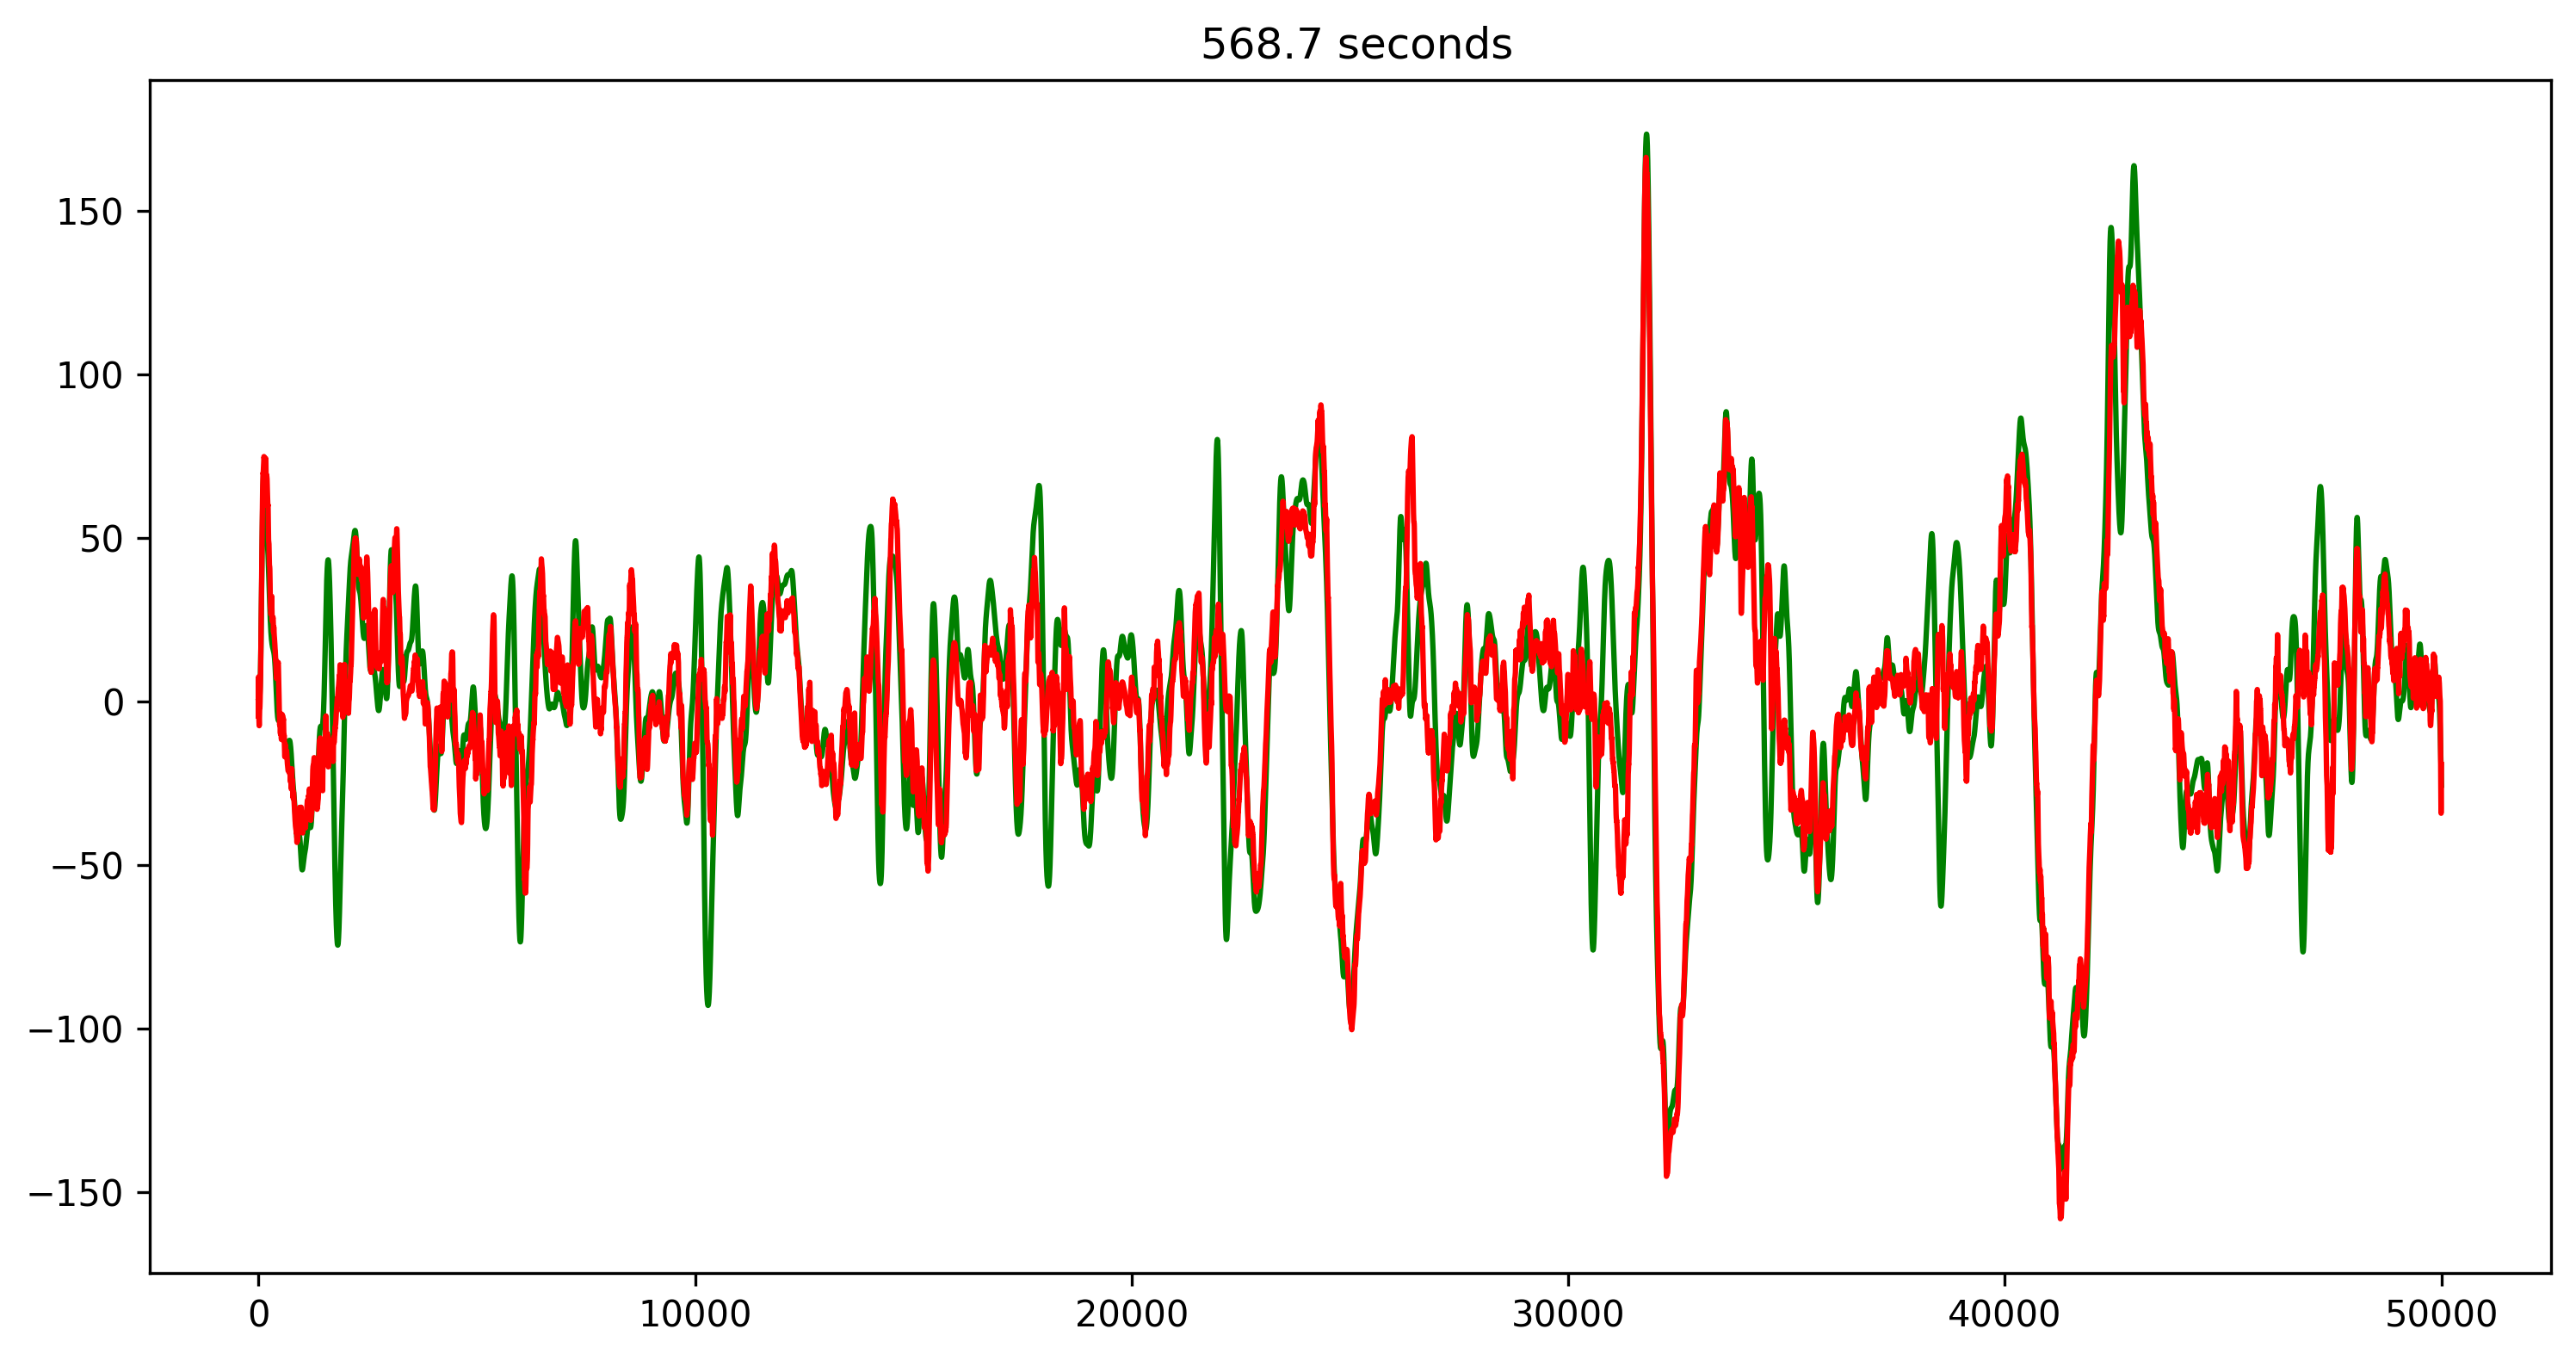

In [9]:
# f = r'/NFS/tyhuang/fhlinXBCG/noscan/170320_CLY/analysis/EyeClose1_noscan.mat'
f = r'../../../EEG範例資料/EyeClose1_noscan.mat'

def norm_ecg(ecg):
    min1, max1 = np.percentile(ecg, [1, 99])
    ecg[ecg>max1] = max1
    ecg[ecg<min1] = min1
    ecg = (ecg - min1)/(max1-min1)
    return ecg


data = mat73.loadmat(f)
eeg_filtered = data['EEG_before_bcg'] * 0
t = time.time()
for ii in range(31):
    eeg_filtered[ii, ...] = butter_bandpass_filter(data['EEG_before_bcg'][ii,:], 1, 40, 5000)

torch.cuda.empty_cache()
device = ('cuda' if torch.cuda.is_available() else 'cpu')
NET = UNet1d(n_channels=1, n_classes=31, nfilter=8).to(device)
#NET = torch.load('pretrainbcg_f8.pt')
#NET.outc = OutConv(8, 31)
NET = NET.to(device)
optimizer = torch.optim.Adam(NET.parameters(), lr=5e-4)
optimizer.zero_grad()
maxlen = data['ECG'].size

loss_list = []
count = 0
ecg = norm_ecg(data['ECG'])
for ii in range(5000):
    if ii % 10 == 0:
        sys.stdout.write('.')
    index = random.randrange(maxlen-20000)
    ECG = ecg[index:(index+20000)]
    EEG = eeg_filtered[:, index:(index+20000)]
    ECG_d = torch.from_numpy(ECG[None, ...][None, ...]).to(device).float()
    EEG_d = torch.from_numpy(EEG[None, ...]).to(device).float()

    # step 3: forward path of UNET
    logits = NET(ECG_d)
    loss = nn.MSELoss()(logits, EEG_d)
    loss_list.append(loss.item())


    # Step 5: Perform back-propagation
    loss.backward() #accumulate the gradients
    optimizer.step() #Update network weights according to the optimizer
    optimizer.zero_grad() #empty the gradients


    if (ii + 1) % 500 == 0: #plot results per 500 iterations
        print('mse loss: ', np.mean(loss_list))
        loss_list = []
        EEG = eeg_filtered[:, :50000]
        ECG = data['ECG'][:50000]
        ECG_d = torch.from_numpy(ECG[None, ...][None, ...]).to(device).float()
        EEG_d = torch.from_numpy(EEG[None, ...]).to(device).float()
        logits = NET(ECG_d)        
        EEG_pred = logits.cpu().detach().numpy()
        plt.figure(figsize=(12, 6), dpi=300)

        plt.plot(EEG[0, ...], 'g')
        plt.plot(EEG[0, ...] - EEG_pred[0, 0, ...], 'r')
        time1 = round(time.time() - t, 1)
        plt.title(f' {time1} seconds')
        plt.show()


# remove BCG from the whole dataset
EEG = eeg_filtered
ECG = data['ECG']
ECG_d = torch.from_numpy(ECG[None, ...][None, ...]).to(device).float()
EEG_d = torch.from_numpy(EEG[None, ...]).to(device).float()
logits = NET(ECG_d)
BCG_pred = logits.cpu().detach().numpy()[0, ...]
EEG_removeBCG_unet = eeg_filtered - BCG_pred

